# Import Libraries

In [1]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import torch_scatter
import e3nn
from e3nn import o3
from typing import Dict, Union
from typing import Dict, Union
import pickle
from torch.nn.modules.loss import _Loss
from torch_geometric.data import Data
from torch_cluster import radius_graph

from e3nn.math import soft_one_hot_linspace
from e3nn.nn import Gate
from e3nn.nn.models.gate_points_2101 import Convolution, smooth_cutoff, tp_path_exists

from ase.io import read, write
from ase.build import sort
import json

import matplotlib.pyplot as plt
import math
import time
from tqdm import tqdm

# crystal structure data
from ase import Atom, Atoms
from ase.neighborlist import neighbor_list
from ase.visualize.plot import plot_atoms
palette = ['#43AA8B', '#F8961E', '#F94144']
sub = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

# data pre-processing and visualization
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.lines import Line2D
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
from scipy.interpolate import interp1d

# utilities
import time
from mendeleev import element
from tqdm import tqdm
from pathlib import Path, PurePath
import os
# from utils.utils_data import (load_data, train_valid_test_split, plot_example, plot_predictions, weighted_mean, r2_score)
# from utils.utils_model import Network, visualize_layers, train

bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

# Create a colormap based on the number of unique symbols
datasets = ['g', 'y', 'r']
colors = dict(zip(datasets, palette))
cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', [palette[k] for k in [0,2,1]])

# API for Materials Project
my_api_key = 'wihuW5J4CTHX0JjEwxdyiP7XzPBi6sJh'
# Check device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print('torch device:' , device)


torch device: cuda:0


# Utils_Data

In [2]:
# model
import torch
import torch_geometric as tg

# data pre-processing
import numpy as np
import pandas as pd
import pickle as pkl
from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde

# data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
from ase import Atoms
from ase.visualize.plot import plot_atoms

# utilities
from tqdm import tqdm


# format progress bar
bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'
tqdm.pandas(bar_format=bar_format)


# standard formatting for plots
fontsize = 16
textsize = 14
#sub = str.maketrans("0123456789", "в‚Ђв‚Ѓв‚‚в‚ѓв‚„в‚…в‚†в‚‡в‚€в‚‰")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['font.size'] = fontsize
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['legend.fontsize'] = textsize


# colors for datasets
palette = ['#2876B2', '#F39957', '#67C7C2', '#C86646']
datasets = ['train', 'valid', 'test']
colors = dict(zip(datasets, palette[:-1]))
cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', [palette[k] for k in [0,2,1]])


def load_data(filename):
    # load data from a pkl file and derive formula and species columns from structure
    df = pd.read_pickle(filename)
    df['species'] = df['structure'].map(lambda x: list(set(x.get_chemical_symbols())))
    species = sorted(list(set(df['species'].sum())))

    #df['energies'] = df['energies'].apply(eval).apply(np.array)
    #df['absorption_coefficient'] = df['absorption_coefficient'].apply(eval).apply(np.array)
    #df['pdos'] = df['pdos'].apply(eval)

    return df, species

def train_valid_test_split(df, species, valid_size, test_size, seed=12, plot=False):
    # perform an element-balanced train/valid/test split
    print('split train/dev ...')
    dev_size = valid_size + test_size
    stats = get_element_statistics(df, species)
    idx_train, idx_dev = split_data(stats, dev_size, seed)
    
    print('split valid/test ...')
    stats_dev = get_element_statistics(df.iloc[idx_dev], species)
    idx_valid, idx_test = split_data(stats_dev, test_size/dev_size, seed)
    idx_train += df[~df.index.isin(idx_train + idx_valid + idx_test)].index.tolist()

    print('number of training examples:', len(idx_train))
    print('number of validation examples:', len(idx_valid))
    print('number of testing examples:', len(idx_test))
    print('total number of examples:', len(idx_train + idx_valid + idx_test))
    assert len(set.intersection(*map(set, [idx_train, idx_valid, idx_test]))) == 0

    if plot:
        # plot element representation in each dataset
        stats['train'] = stats['data'].map(lambda x: element_representation(x, np.sort(idx_train)))
        stats['valid'] = stats['data'].map(lambda x: element_representation(x, np.sort(idx_valid)))
        stats['test'] = stats['data'].map(lambda x: element_representation(x, np.sort(idx_test)))
        stats = stats.sort_values('symbol')

        fig, ax = plt.subplots(2,1, figsize=(14,7))
        b0, b1 = 0., 0.
        for i, dataset in enumerate(datasets):
            split_subplot(ax[0], stats[:len(stats)//2], species[:len(stats)//2], dataset, bottom=b0, legend=True)
            split_subplot(ax[1], stats[len(stats)//2:], species[len(stats)//2:], dataset, bottom=b1)

            b0 += stats.iloc[:len(stats)//2][dataset].values
            b1 += stats.iloc[len(stats)//2:][dataset].values

        fig.tight_layout()
        fig.subplots_adjust(hspace=0.1)

    return idx_train, idx_valid, idx_test


def get_element_statistics(df, species):    
    # create dictionary indexed by element names storing index of samples containing given element
    species_dict = {k: [] for k in species}
    for entry in df.itertuples():
        for specie in entry.species:
            species_dict[specie].append(entry.Index)

    # create dataframe of element statistics
    stats = pd.DataFrame({'symbol': species})
    stats['data'] = stats['symbol'].astype('object')
    for specie in species:
        stats.at[stats.index[stats['symbol'] == specie].values[0], 'data'] = species_dict[specie]
    stats['count'] = stats['data'].apply(len)

    return stats


def split_data(df, test_size, seed):
    # initialize output arrays
    idx_train, idx_test = [], []
    
    # remove empty examples
    df = df[df['data'].str.len()>0]
    
    # sort df in order of fewest to most examples
    df = df.sort_values('count')
    
    for _, entry in tqdm(df.iterrows(), total=len(df), bar_format=bar_format):
        df_specie = entry.to_frame().T.explode('data')

        try:
            idx_train_s, idx_test_s = train_test_split(df_specie['data'].values, test_size=test_size,
                                                       random_state=seed)
        except:
            # too few examples to perform split - these examples will be assigned based on other constituent elements
            # (assuming not elemental examples)
            pass

        else:
            # add new examples that do not exist in previous lists
            idx_train += [k for k in idx_train_s if k not in idx_train + idx_test]
            idx_test += [k for k in idx_test_s if k not in idx_train + idx_test]
    
    return idx_train, idx_test


def element_representation(x, idx):
    # get fraction of samples containing given element in dataset
    return len([k for k in x if k in idx])/len(x)


def split_subplot(ax, df, species, dataset, bottom=0., legend=False):    
    # plot element representation
    width = 0.4
    color = [int(colors[dataset].lstrip('#')[i:i+2], 16)/255. for i in (0,2,4)]
    bx = np.arange(len(species))
        
    ax.bar(bx, df[dataset], width, fc=color+[0.7], ec=color, lw=1.5, bottom=bottom, label=dataset)
        
    ax.set_xticks(bx)
    ax.set_xticklabels(species)
    ax.tick_params(direction='in', length=0, width=1)
    ax.set_ylim(top=1.18)
    if legend: ax.legend(frameon=False, ncol=3, loc='upper left')
        

def plot_example(df, i=12, label_edges=False):
    # plot an example crystal structure and graph
    entry = df.iloc[i]['data']

    # get graph with node and edge attributes
    g = tg.utils.to_networkx(entry, node_attrs=['symbol'], edge_attrs=['edge_len'], to_undirected=True)

    # remove self-loop edges for plotting
    g.remove_edges_from(list(nx.selfloop_edges(g)))
    node_labels = dict(zip([k[0] for k in g.nodes.data()], [k[1]['symbol'] for k in g.nodes.data()]))
    edge_labels = dict(zip([(k[0], k[1]) for k in g.edges.data()], [k[2]['edge_len'] for k in g.edges.data()]))

    # project positions of nodes to 2D for plotting
    pos = dict(zip(list(g.nodes), [np.roll(k,2)[:-1][::-1] for k in entry.pos.numpy()]))

    # plot unit cell
    fig, ax = plt.subplots(1,2, figsize=(14,10), gridspec_kw={'width_ratios': [2,3]})
    atoms = Atoms(symbols=entry.symbol, positions=entry.pos.numpy(), cell=entry.lattice.squeeze().numpy(), pbc=True)
    symbols = np.unique(entry.symbol)
    z = dict(zip(symbols, range(len(symbols))))
    norm = plt.Normalize(vmin=0, vmax=len(symbols)-1)
    color = [mpl.colors.to_hex(k) for k in cmap(norm([z[j] for j in entry.symbol]))]
    plot_atoms(atoms, ax[0], radii=0.25, colors=color, rotation=('0x,90y,0z'))

    # plot graph
    nx.draw_networkx(g, ax=ax[1], labels=node_labels, pos=pos, font_family='Arial', node_size=500, node_color=color,
                     edge_color='gray')
    
    if label_edges:
        nx.draw_networkx_edge_labels(g, ax=ax[1], edge_labels=edge_labels, pos=pos, label_pos=0.5, font_family='Arial')
    
    # format axes
    ax[0].set_xlabel(r'$x_1\ (\AA)$')
    ax[0].set_ylabel(r'$x_2\ (\AA)$')
    ax[0].set_title('Crystal structure', fontsize=fontsize)
    ax[1].set_aspect('equal')
    ax[1].axis('off')
    ax[1].set_title('Crystal graph', fontsize=fontsize)
    pad = np.array([-0.5, 0.5])
    ax[1].set_xlim(np.array(ax[1].get_xlim()) + pad)
    ax[1].set_ylim(np.array(ax[1].get_ylim()) + pad)
    fig.subplots_adjust(wspace=0.4)


# def plot_predictions(df, idx, column, header, title=None, plot_gt=True):    
#     # get quartiles
#     i_mse = np.argsort(df.iloc[idx]['mse'])
#     ds = df.iloc[idx].iloc[i_mse][['formula','energies_interp', column, 'y_pred', 'mse']].reset_index(drop=True)
#     quartiles = np.quantile(ds['mse'].values, (0.25, 0.5, 0.75, 1.))
#     iq = [0] + [np.argmin(np.abs(ds['mse'].values - k)) for k in quartiles]
    
#     n = 6
#     s = np.concatenate([np.sort(np.random.choice(np.arange(iq[k-1], iq[k], 1), size=n, replace=False)) for k in range(1,5)])
#     x = df.iloc[0]['energies_interp']

#     fig, axs = plt.subplots(4,n+1, figsize=(13,5), gridspec_kw={'width_ratios': [0.7] + [1]*n})
#     gs = axs[0,0].get_gridspec()
    
#     # remove the underlying axes
#     for ax in axs[:,0]:
#         ax.remove()

#     # add long axis
#     axl = fig.add_subplot(gs[:,0])

#     # plot quartile distribution
#     y_min, y_max = ds['mse'].min(), ds['mse'].max()
#     y = np.linspace(y_min, y_max, 500)
#     kde = gaussian_kde(ds['mse'])
#     p = kde.pdf(y)
#     axl.plot(p, y, color='black')
#     cols = [palette[k] for k in [2,0,1,3]][::-1]
#     qs =  list(quartiles)[::-1] + [0]
#     for i in range(len(qs)-1):
#         axl.fill_between([p.min(), p.max()], y1=[qs[i], qs[i]], y2=[qs[i+1], qs[i+1]], color=cols[i], lw=0, alpha=0.5)
#     axl.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#     axl.invert_yaxis()
#     axl.set_xticks([])
#     axl.set_ylabel('Mean Squared Error')

#     fontsize = 14
#     cols = np.repeat(cols[::-1], n)
#     axs = axs[:,1:].ravel()
#     for k in range(4*n):
#         ax = axs[k]
#         i = s[k]
#         if plot_gt:
#             ax.plot(x, ds.iloc[i][column], color='black')
#         ax.plot(x, ds.iloc[i]['y_pred'], color=cols[k])
#         ax.set_xticks([]); ax.set_yticks([])
#         ax.set_title(ds.iloc[i]['formula'].translate(sub), fontname='DejaVu Sans', fontsize=fontsize, y=1.0)
        
#     fig.tight_layout()
#     fig.subplots_adjust(hspace=0.5)
#     if title: fig.suptitle(title, ha='center', y=1.05, fontsize=fontsize + 4)
#     fig.savefig(f"{header}_{title}_spectra.pdf")


# def plot_partials(model, df, idx, device='cpu'):
#     # randomly sample r compounds from the dataset
#     r = 6
#     ids = np.random.choice(df.iloc[idx][df.iloc[idx]['pdos'].str.len()>0].index.tolist(), size=r, replace=False)
    
#     # initialize figure axes
#     N = df.iloc[ids]['species'].str.len().max()
#     fig, ax = plt.subplots(r, N+1, figsize=(2.4*(N+1),1.2*r), sharex=True, sharey=True)

#     # predict output of each site for each sample
#     for row, i in enumerate(ids):
#         entry = df.iloc[i]
#         d = tg.data.Batch.from_data_list([entry.data])

#         model.eval()
#         with torch.no_grad():
#             d.to(device)
#             output = model(d).cpu().numpy()

#         # average contributions from the same specie over all sites
#         n = len(entry.species)
#         pdos = dict(zip(entry.species, [np.zeros((output.shape[1])) for k in range(n)]))
#         for j in range(output.shape[0]):
#             pdos[entry.data.symbol[j]] += output[j,:]

#         for j, s in enumerate(entry.species):
#             pdos[s] /= entry.data.symbol.count(s)

#         # plot total DoS
#         ax[row,0].plot(entry.phfreq, entry.phdos, color='black')
#         ax[row,0].plot(entry.phfreq, entry.phdos_pred, color=palette[0])
#         ax[row,0].set_title(entry.formula.translate(sub), fontsize=fontsize - 2, y=0.99)
#         ax[row,0].set_xticks([]); ax[row,0].set_yticks([])

#         # plot partial DoS
#         for j, s in enumerate(entry.species):
#             ax[row,j+1].plot(entry.phfreq, entry.pdos[s], color='black')
#             ax[row,j+1].plot(entry.phfreq, pdos[s]/pdos[s].max(), color=palette[1], lw=2)
#             ax[row,j+1].set_title(s, fontsize=fontsize - 2, y=0.99)
#             ax[row,j+1].set_xticks([]); ax[row,j+1].set_yticks([])

#         for j in range(len(entry.species) + 1, N+1):
#             ax[row,j].remove()

#     try: fig.supylabel('Intensity', fontsize=fontsize, x=0.08)
#     except: pass
#     else: fig.supxlabel('Frequency', fontsize=fontsize, y=0.06)
#     fig.subplots_adjust(hspace=0.8)


# def weighted_mean(x, y):
#     """
#     Calculate the weighted mean of Y with respect to X for each row.
    
#     Parameters:
#         x (array-like): Array of X values with shape (n_rows, n_columns).
#         y (array-like): Array of Y values with shape (n_rows, n_columns).
        
#     Returns:
#         array-like: Weighted mean of Y with respect to X for each row.
#     """
#     weighted_sum = np.sum(x * y, axis=1)  # Sum along each row
#     sum_of_weights = np.sum(x, axis=1)  # Sum along each row
#     weighted_mean = weighted_sum / sum_of_weights
#     return weighted_mean

# def r2_score(y_true, y_pred):
#     """
#     Calculate the R^2 (coefficient of determination) value between true and predicted values.
    
#     Parameters:
#         y_true (array-like): Array of true Y values.
#         y_pred (array-like): Array of predicted Y values.
        
#     Returns:
#         float: R^2 value.
#     """
#     # Calculate the mean of true values
#     y_true_mean = np.mean(y_true)
#     # Calculate the total sum of squares
#     ss_total = np.sum((y_true - y_true_mean) ** 2)
#     # Calculate the residual sum of squares
#     ss_residual = np.sum((y_true - y_pred) ** 2)
#     # Calculate R^2
#     r_squared = 1 - (ss_residual / ss_total)
#     return r_squared

def visualize_layers(model):
    layer_dst = dict(zip(['sc', 'lin1', 'tp', 'lin2'], ['gate', 'tp', 'lin2', 'gate']))
    try: layers = model.mp.layers
    except: layers = model.layers

    num_layers = len(layers)
    num_ops = max([len([k for k in list(layers[i].first._modules.keys()) if k not in ['fc', 'alpha']])
                   for i in range(num_layers-1)])

    fig, ax = plt.subplots(num_layers, num_ops, figsize=(14,3.5*num_layers))
    for i in range(num_layers - 1):
        ops = layers[i].first._modules.copy()
        ops.pop('fc', None); ops.pop('alpha', None)
        for j, (k, v) in enumerate(ops.items()):
            ax[i,j].set_title(k, fontsize=textsize)
            v.cpu().visualize(ax=ax[i,j])
            ax[i,j].text(0.7,-0.15,'--> to ' + layer_dst[k], fontsize=textsize-2, transform=ax[i,j].transAxes)

    layer_dst = dict(zip(['sc', 'lin1', 'tp', 'lin2'], ['output', 'tp', 'lin2', 'output']))
    ops = layers[-1]._modules.copy()
    ops.pop('fc', None); ops.pop('alpha', None)
    for j, (k, v) in enumerate(ops.items()):
        ax[-1,j].set_title(k, fontsize=textsize)
        v.cpu().visualize(ax=ax[-1,j])
        ax[-1,j].text(0.7,-0.15,'--> to ' + layer_dst[k], fontsize=textsize-2, transform=ax[-1,j].transAxes)

    fig.subplots_adjust(wspace=0.3, hspace=0.5)


def loglinspace(rate, step, end=None):
    t = 0
    while end is None or t <= end:
        yield t
        t = int(t + 1 + step*(1 - math.exp(-t*rate/step)))

        
def evaluate(model, dataloader, loss_fn, loss_fn_mae, device):
    model.eval()
    loss_cumulative = 0.
    loss_cumulative_mae = 0.
    start_time = time.time()
    with torch.no_grad():
        for j, d in enumerate(dataloader):
            d.to(device)
            output = model(d)
            loss = loss_fn(output, d.y).cpu()
            loss_mae = loss_fn_mae(output, d.y).cpu()
            loss_cumulative = loss_cumulative + loss.detach().item()
            loss_cumulative_mae = loss_cumulative_mae + loss_mae.detach().item()
    return loss_cumulative/len(dataloader), loss_cumulative_mae/len(dataloader)

class BandLoss(_Loss):
    def __init__(self, size_average = None, reduce = None, reduction: str = 'mean') -> None:
        super(BandLoss, self).__init__(size_average, reduce, reduction)

    def forward(self, input, target):
        return torch.sum(torch.pow(torch.abs(input - target)/torch.max(torch.abs(target)), 2)) \
               /torch.numel(target)


class CustomCompose(torch.nn.Module):
    def __init__(self, first, second):
        super().__init__()
        self.first = first
        self.second = second
        self.irreps_in = self.first.irreps_in
        self.irreps_out = self.second.irreps_out

    def forward(self, *input):
        x = self.first(*input)
        self.first_out = x.clone()
        x = self.second(x)
        self.second_out = x.clone()
        return x

# Import Data

In [3]:
main_dir = Path(os.environ['HOME'] / PurePath('hw', 'Deep_Learning', 'Project'))
if main_dir.exists():
    print('Main Directory:')
    print(main_dir)
else:
    print('Directory does not exists')

Main Directory:
/trinity/home/khasan.akhmadiev/hw/Deep_Learning/Project


In [4]:
# Function to simplify POSCAR and convert to direct coordinates
def simplify_and_convert_poscar(xyz_path, poscar_path):
    # Read the XYZ file
    atoms = read(xyz_path)

    # Sort the atoms by chemical symbols (puts all Ta first, then all Se)
    atoms_sorted = sort(atoms)

    # Convert to Direct coordinates
    atoms_sorted.set_scaled_positions(atoms_sorted.get_scaled_positions())

    # Simplify the POSCAR format
    symbols = atoms_sorted.get_chemical_symbols()
    unique_symbols = list(dict.fromkeys(symbols))  # Get unique element types in order of appearance
    counts = [symbols.count(sym) for sym in unique_symbols]  # Count how many of each element

    # Write the POSCAR file in VASP format with the corrected atomic order and Direct coordinates
    write(poscar_path, atoms_sorted, format='vasp', direct=True)

    # Modify the POSCAR file to have the simplified element list and counts
    with open(poscar_path, 'r') as f:
        poscar_lines = f.readlines()

    # Replace the 5th and 6th lines with unique element types and their counts
    poscar_lines[5] = '  '.join(unique_symbols) + '\n'  # Line with unique symbols (e.g., Ta Se)
    poscar_lines[6] = '  '.join(map(str, counts)) + '\n'  # Line with counts (e.g., 7 6)

    # Write the modified POSCAR back to file
    with open(poscar_path, 'w') as f:
        f.writelines(poscar_lines)

In [5]:
# Example usage
xyz_dir = Path('/trinity/home/khasan.akhmadiev/research/diamane/c2db/materials')
poscar_dir = Path("/trinity/home/khasan.akhmadiev/research/diamane/c2db/poscar_output")

# Путь к директории с файлами .xyz
xyz_dir = Path('/trinity/home/khasan.akhmadiev/research/diamane/c2db/materials')

# Проход по всем папкам и файлам в указанной директории
i = 0
for root, _, files in os.walk(xyz_dir):
    for file in files:
        if file.endswith('.xyz'):
            xyz_file = os.path.join(root, file)
            poscar_file = poscar_dir / f"POSCAR-{i}.vasp"
            i += 1
            simplify_and_convert_poscar(xyz_file, poscar_file)
            # print(f"Converted {xyz_file} to {poscar_file}")
        elif file.endswith('.json'):
            json_file = Path( os.path.join(root, file) )
            data = json.loads((json_file).read_text())
print(f'Number of 2D structures: {i+1}')

KeyboardInterrupt: 

In [75]:
from mp_api.client import MPRester

with MPRester(my_api_key) as mpr:
    docs = mpr.materials.summary.search(
            has_props=["dielectric", "dos"]
        )
    with open(main_dir / "d.pkl", "wb") as file:
        pickle.dump(data, file)

Retrieving SummaryDoc documents:   0%|          | 0/5720 [00:00<?, ?it/s]

In [77]:
docs[0].structure

Structure Summary
Lattice
    abc : 8.77994252 10.81554824 10.81554824
 angles : 90.0 90.0 90.0
 volume : 1027.0432913796221
      A : np.float64(8.77994252) np.float64(0.0) np.float64(-0.0)
      B : np.float64(0.0) np.float64(10.81554824) np.float64(-0.0)
      C : np.float64(0.0) np.float64(0.0) np.float64(10.81554824)
    pbc : True True True
PeriodicSite: Cl (7.85, 3.758, 6.569) [0.8941, 0.3474, 0.6073]
PeriodicSite: Cl (5.32, 7.058, 1.161) [0.6059, 0.6526, 0.1073]
PeriodicSite: Cl (7.85, 6.569, 3.758) [0.8941, 0.6073, 0.3474]
PeriodicSite: Cl (7.85, 9.655, 1.65) [0.8941, 0.8927, 0.1526]
PeriodicSite: Cl (0.9296, 9.165, 1.161) [0.1059, 0.8474, 0.1073]
PeriodicSite: Cl (3.46, 1.65, 6.569) [0.3941, 0.1526, 0.6073]
PeriodicSite: Cl (0.9296, 7.058, 4.247) [0.1059, 0.6526, 0.3927]
PeriodicSite: Cl (3.46, 3.758, 9.655) [0.3941, 0.3474, 0.8927]
PeriodicSite: Cl (3.46, 6.569, 1.65) [0.3941, 0.6073, 0.1526]
PeriodicSite: Cl (7.85, 1.65, 9.655) [0.8941, 0.1526, 0.8927]
PeriodicSite: Cl (0.9

In [68]:
df, species = load_data(main_dir / "d.pkl")
df.head()

KeyError: 'structure'

## Data Structures

In [5]:
data_file = '/trinity/home/khasan.akhmadiev/hw/Deep_Learning/Project/absorption_mp_data.pkl'
df, species = load_data(data_file)
df.head()

,id,formula,structure,energies,absorption_coefficient,imag_dielectric,real_dielectric,energy_max,bandgap,species
0,mp-546266,DyBi2IO4,"(Atom('Dy', [np.float64(0.0), np.float64(0.0),...","[0.0, 0.0277, 0.0554, 0.0831, 0.1109, 0.1386, ...","[0.0, 0.8362304735329499, 3.309178082718349, 7...","[0.0, 0.0015666666666666665, 0.0031, 0.0046666...","[6.9163, 6.916533333333334, 6.9172, 6.9182, 6....",55.4328,1.3818000000000001,"[I, Dy, Bi, O]"
1,mp-9583,K2ZnF4,"(Atom('K', [np.float64(1.2531985199117757), np...","[0.0, 0.0399, 0.0798, 0.1197, 0.1596, 0.1995, ...","[0.0, 0.1362578822994739, 0.4541860898852432, ...","[0.0, 0.0001, 0.00016666666666666666, 0.0002, ...","[2.2021333333333333, 2.202166666666667, 2.2022...",79.7804,4.3866,"[K, Zn, F]"
2,mp-22988,CsGeCl3,"(Atom('Cs', [np.float64(7.78333021211009), np....","[0.0, 0.029, 0.058, 0.087, 0.116, 0.1449, 0.17...","[0.0, 0.515935972729374, 2.0145311056971553, 4...","[0.0, 0.0007, 0.0013666666666666669, 0.0020333...","[3.975733333333333, 3.9758333333333336, 3.9761...",57.9759,2.178,"[Ge, Cs, Cl]"
3,mp-861502,AcFeO3,"(Atom('Ac', [np.float64(0.0), np.float64(0.0),...","[0.0, 0.0587, 0.1174, 0.176, 0.2347, 0.2934, 0...","[0.0, 11295.053197761259, 44864.495977063896, ...","[0.0, 30.1914, 49.9196, 37.98413333333333, 21....","[67.54320000000001, 59.6215, 29.6067, 1.281, -...",117.3625,0.0,"[O, Ac, Fe]"
4,mp-1025029,PrHSe,"(Atom('Pr', [np.float64(-2.0265362), np.float6...","[0.0, 0.0365, 0.073, 0.1095, 0.1459, 0.1824, 0...","[0.0, 1.6849892209331498, 6.697792903781345, 1...","[0.0, 0.0026999999999999997, 0.005366666666666...","[8.784633333333334, 8.7851, 8.786566666666667,...",72.9718,1.9455999999999998,"[Se, Pr, H]"


<>:66: SyntaxWarning: invalid escape sequence '\A'
<>:66: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_659639/2570164695.py:66: SyntaxWarning: invalid escape sequence '\A'
  ax.set_xlabel('Lattice parameter ($\AA$)')


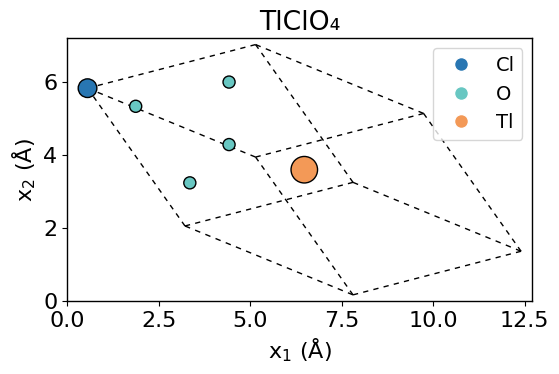

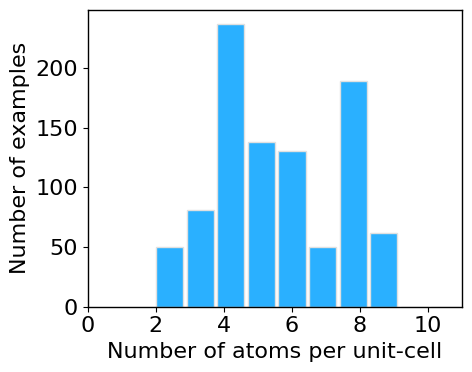

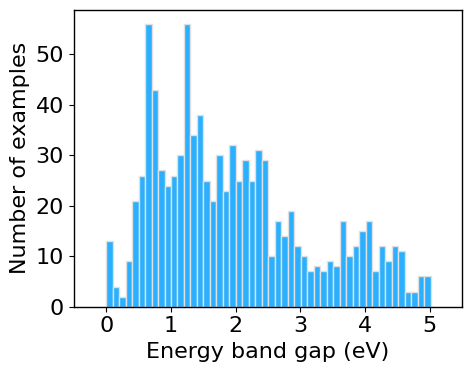

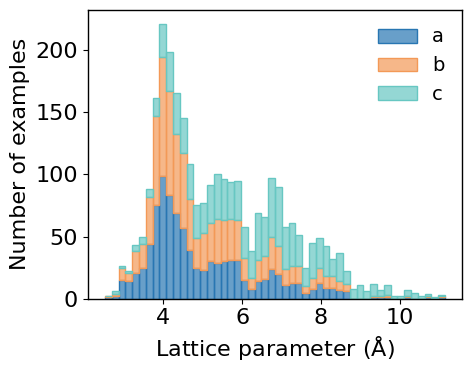

In [7]:
# plot an example structure
i = 16 # structure index in dataframe
struct = df.iloc[i]['structure']
symbols = np.unique(list(struct.symbols))
z = dict(zip(symbols, range(len(symbols))))

# Create the plot
fig, ax = plt.subplots(figsize=(6,6))
norm = plt.Normalize(vmin=0, vmax=len(symbols)-1)
color = [mpl.colors.to_hex(k) for k in cmap(norm([z[j] for j in list(struct.symbols)]))]
plot_atoms(struct, ax, radii=0.25, colors=color, rotation=('45x,45y,0z'))

# Add legend with atom labels
legend_elements = []
for symbol, color in zip(set(symbols), [cmap(norm(i)) for i in range(len(set(symbols)))]):
    legend_elements.append(Line2D([0], [0], marker='o', color='w', label=symbol, markerfacecolor=color, markersize=10))
ax.legend(handles=legend_elements, loc='upper right')

# Set labels and title
ax.set_xlabel(r'$x_1\ (\AA)$')
ax.set_ylabel(r'$x_2\ (\AA)$')
ax.set_title(df.iloc[i]['formula'].translate(sub), fontname='DejaVu Sans')

# data statistics (#Atoms/cell)
sites = [len(s.get_positions()) for s in list(df['structure'])]
fig, ax = plt.subplots(figsize=(5,4))
ax.hist(sites, bins=max(sites), fc='#2ab0ff', ec='#e0e0e0', lw=1, width=0.8)
ax.set_xlim(0.0, 11)
x_ticks = np.arange(0, 12, 2) 
ax.set_xticks(x_ticks)
ax.set_ylabel('Number of examples')
ax.set_xlabel('Number of atoms per unit-cell')
fig.patch.set_facecolor('white')
plt.tight_layout()
#fig.savefig('data-site.pdf')

bandgap = np.array(df['bandgap'])
fig, ax = plt.subplots(figsize=(5,4))
ax.hist(bandgap, bins=50, fc='#2ab0ff', ec='#e0e0e0')
ax.set_xlim(-0.5, 5.5)
x_ticks = np.arange(0, 6, 1) 
ax.set_xticks(x_ticks)
ax.set_xlabel('Energy band gap (eV)')
ax.set_ylabel('Number of examples')
fig.patch.set_facecolor('white')
plt.tight_layout()
#fig.savefig('data-bandgap.pdf')

# lattice parameter statistics
def get_lattice_parameters(data):
    a = []
    len_data = len(data)
    for i in range(len_data):
        d = data.iloc[i]
        a.append(d.structure.cell.cellpar()[:3])
    return np.stack(a)
a = get_lattice_parameters(df)

fig, ax = plt.subplots(figsize=(5,4))
b = 0.
bins = 50
for d, c, n in zip(['a', 'b', 'c'], colors.values(), [a[:,0], a[:,1], a[:,2]]):
    color = [int(c.lstrip('#')[i:i+2], 16)/255. for i in (0,2,4)]
    y, bins, _, = ax.hist(n, bins=bins, fc=color+[0.7], ec=color, bottom=b, label=d)
    b += y
ax.set_xlabel('Lattice parameter ($\AA$)')
ax.set_ylabel('Number of examples')
ax.legend(frameon=False)
plt.tight_layout()
#fig.savefig('data-lattice.pdf')
#print('average lattice parameter (a/b/c):', a[:,0].mean(), '/', a[:,1].mean(), '/', a[:,2].mean())

# Show the plot
plt.show()


## Reconstruction Data

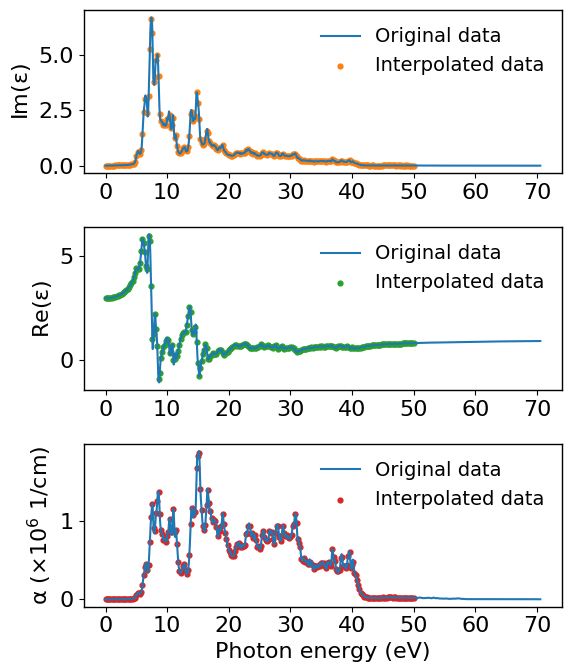

In [8]:
energy_min = 0.0 #Unit of energy in eV
energy_max = 50.0 #Unit of energy in eV
nstep = 251 #Number of the energy points

new_x = np.linspace(energy_min, energy_max, nstep)
def interpolate(row, column):
    interp = interp1d(row['energies'], row[column], kind='linear', fill_value=0, bounds_error=False)
    new_y = interp(new_x)
    return new_y

# Kramers–Kronig relations
def real_refractive(row, imag_esp, real_esp):
    n_refactive = np.sqrt((np.sqrt(row[imag_esp]**2+row[real_esp]**2)+row[real_esp])/2)
    return n_refactive

def imag_refractive(row, imag_esp, real_esp):
    k_refactive = np.sqrt((np.sqrt(row[imag_esp]**2+row[real_esp]**2)-row[real_esp])/2)
    return k_refactive

def reflectance(row, n, k):
    R_reflectance = ((row[n]-1)**2+row[k]**2)/((row[n]+1)**2+row[k]**2)
    return R_reflectance

# Apply the custom function to create a new column
df['energies_interp'] = df.apply(lambda x: new_x, axis=1)
df['imag_dielectric_interp'] = df.apply(lambda row: interpolate(row, 'imag_dielectric'), axis=1)
df['real_dielectric_interp'] = df.apply(lambda row: interpolate(row, 'real_dielectric'), axis=1)
df['absorption_coefficient_interp'] = df.apply(lambda row: interpolate(row, 'absorption_coefficient'), axis=1)
df['n_interp'] = df.apply(lambda row: real_refractive(row, 'imag_dielectric_interp', 'real_dielectric_interp'), axis=1)
df['k_interp'] = df.apply(lambda row: imag_refractive(row, 'imag_dielectric_interp', 'real_dielectric_interp'), axis=1)
df['R_interp'] = df.apply(lambda row: reflectance(row, 'n_interp', 'k_interp'), axis=1)

# Show the plot for compare the original data and interpolated data
plt.figure(figsize=(6, 7))

plt.subplot(3, 1, 1)
plt.plot(df['energies'][i], df['imag_dielectric'][i], label='Original data')
plt.scatter(df['energies_interp'][i], df['imag_dielectric_interp'][i], s=12, marker ='o', alpha=1, color='C1', label='Interpolated data')
x_ticks = np.arange(0, 80, 10) 
plt.xticks(x_ticks)
plt.xlabel('')
plt.ylabel(r'Im($\varepsilon$)')
plt.legend(frameon=False)

plt.subplot(3, 1, 2)
plt.plot(df['energies'][i], df['real_dielectric'][i], label='Original data')
plt.scatter(df['energies_interp'][i], df['real_dielectric_interp'][i], s=12, marker ='o', alpha=1, color='C2', label='Interpolated data')
x_ticks = np.arange(0, 80, 10) 
plt.xticks(x_ticks)
plt.xlabel('')
plt.ylabel(r'Re($\varepsilon$)')
plt.legend(frameon=False)

plt.subplot(3, 1, 3)
plt.plot(df['energies'][i], df['absorption_coefficient'][i]/1.0E6, label='Original data')
plt.scatter(df['energies_interp'][i], df['absorption_coefficient_interp'][i]/1.0E6, s=12, marker ='o', alpha=1, color='C3', label='Interpolated data')
x_ticks = np.arange(0, 80, 10) 
plt.xticks(x_ticks)
plt.xlabel('Photon energy (eV)')
plt.ylabel(r'$\alpha$ ($\times 10^6$ 1/cm)')
plt.legend(frameon=False)

plt.tight_layout()
#plt.savefig('data-interpolation.pdf')
plt.show()


## Feature Representation

In [9]:
# one-hot encoding atom type
def one_hot_encoding_atoms(main_dir, load, range_atoms):
    if load:
        # TYPE encoding
        with (main_dir / 'type_encoding.pkl').open(mode='rb') as f:
            type_encoding = pickle.load(f)
            f.close()

        # TYPE
        with (main_dir / 'type_onehot.pkl').open(mode='rb') as f:
            type_onehot = pickle.load(f)
            f.close()
        
        # MASS
        with (main_dir / 'mass_onehot.pkl').open(mode='rb') as f:
            mass_onehot = pickle.load(f)
            f.close()

        # DIPOLE
        with (main_dir / 'dipole_onehot.pkl').open(mode='rb') as f:
            dipole_onehot = pickle.load(f)
            f.close()

        # RADIUS
        with (main_dir / 'radius_onehot.pkl').open(mode='rb') as f:
            radius_onehot = pickle.load(f)
            f.close()

    else:
        type_encoding = {}
        specie_mass = []
        specie_dipole = []
        specie_radius = []
        for Z in tqdm(range_atoms, bar_format=bar_format):              #Change 109 to 119 to increase the number of elements
            specie = Atom(Z)
            type_encoding[specie.symbol] = Z - 1
            Z_mass = specie.mass                                           # Atomic Mass (amu)
            Z_dipole = element(specie.symbol).dipole_polarizability        # Dipole Polarizability (a0^3)
            if Z_dipole == None:
                Z_dipole = 67.0
            Z_radius = element(specie.symbol).covalent_radius_pyykko       # Covalent radius by Bragg (pm)
            specie_mass.append(Z_mass)
            specie_dipole.append(Z_dipole)
            specie_radius.append(Z_radius) 

        # TYPE Encoding
        with (main_dir / 'type_encoding.pkl').open(mode='wb') as f:
            pickle.dump(type_encoding, f)
            f.close()

        # TYPE
        type_onehot = torch.eye(len(type_encoding))
        with (main_dir / 'type_onehot.pkl').open(mode='wb') as f:
            pickle.dump(type_onehot, f)
            f.close()

        # MASS
        mass_onehot = torch.diag(torch.tensor(specie_mass))
        with (main_dir / 'mass_onehot.pkl').open(mode='wb') as f:
            pickle.dump(mass_onehot, f)
            f.close()

        # DIPOLE
        dipole_onehot = torch.diag(torch.tensor(specie_dipole))
        with (main_dir / 'dipole_onehot.pkl').open(mode='wb') as f:
            pickle.dump(dipole_onehot, f)
            f.close()

        # RADIUS
        radius_onehot = torch.diag(torch.tensor(specie_radius))
        with (main_dir / 'radius_onehot.pkl').open(mode='wb') as f:
            pickle.dump(radius_onehot, f)
            f.close()

    return type_encoding, type_onehot, mass_onehot, dipole_onehot, radius_onehot

type_encoding, type_onehot, mass_onehot, dipole_onehot, radius_onehot = one_hot_encoding_atoms(
    main_dir=main_dir,
    load=True,
    range_atoms=np.arange(1, 119, 1),
    )

In [10]:

# Find the scale value
tmp = np.array([df.iloc[i]['bandgap'] for i in range(len(df))])
#scale_data = np.median(np.max(tmp, axis=0))
#print(scale_data)
#/scale_data

# build data
def build_data(entry, type_encoding, type_onehot, r_max=5., pred_y_name=None):
    symbols = list(entry.structure.symbols).copy()
    positions = torch.from_numpy(entry.structure.positions.copy())
    lattice = torch.from_numpy(entry.structure.cell.array.copy()).unsqueeze(0)

    # edge_src and edge_dst are the indices of the central and neighboring atom, respectively
    # edge_shift indicates whether the neighbors are in different images or copies of the unit cell
    edge_src, edge_dst, edge_shift = neighbor_list("ijS", a=entry.structure, cutoff=r_max, self_interaction=True)
    
    # compute the relative distances and unit cell shifts from periodic boundaries
    edge_batch = positions.new_zeros(positions.shape[0], dtype=torch.long)[torch.from_numpy(edge_src)]
    edge_vec = (positions[torch.from_numpy(edge_dst)]
                - positions[torch.from_numpy(edge_src)]
                + torch.einsum('ni,nij->nj', torch.tensor(edge_shift, dtype=default_dtype), lattice[edge_batch]))

    # compute edge lengths (rounded only for plotting purposes)
    edge_len = np.around(edge_vec.norm(dim=1).numpy(), decimals=2)
    
    data = tg.data.Data(
        pos=positions, lattice=lattice, symbol=symbols,
        x_mass=mass_onehot[[type_encoding[specie] for specie in symbols]],       # atomic mass (node feature)
        x_dipole=dipole_onehot[[type_encoding[specie] for specie in symbols]],   # atomic dipole polarizability (node feature)
        x_radius=radius_onehot[[type_encoding[specie] for specie in symbols]],   # atomic covalent radius (node feature)
        z=type_onehot[[type_encoding[specie] for specie in symbols]],            # atom type (node attribute)
        edge_index=torch.stack([torch.LongTensor(edge_src), torch.LongTensor(edge_dst)], dim=0),
        edge_shift=torch.tensor(edge_shift, dtype=default_dtype),
        edge_vec=edge_vec, edge_len=edge_len,
        y=torch.from_numpy(entry[pred_y_name])
    )
    
    return data

r_max = 6. # cutoff radius
df['data'] = df.apply(lambda x: build_data(x, type_encoding, type_onehot, r_max, 'bandgap'), axis=1)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

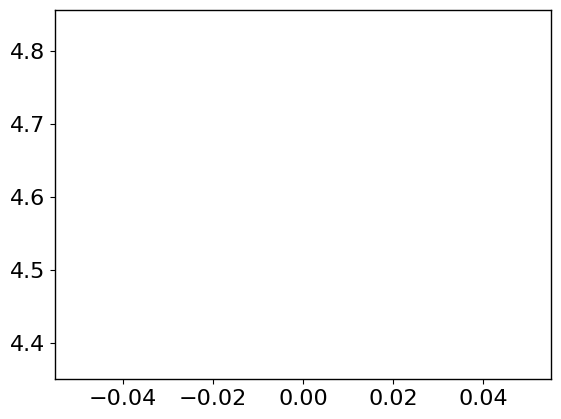

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

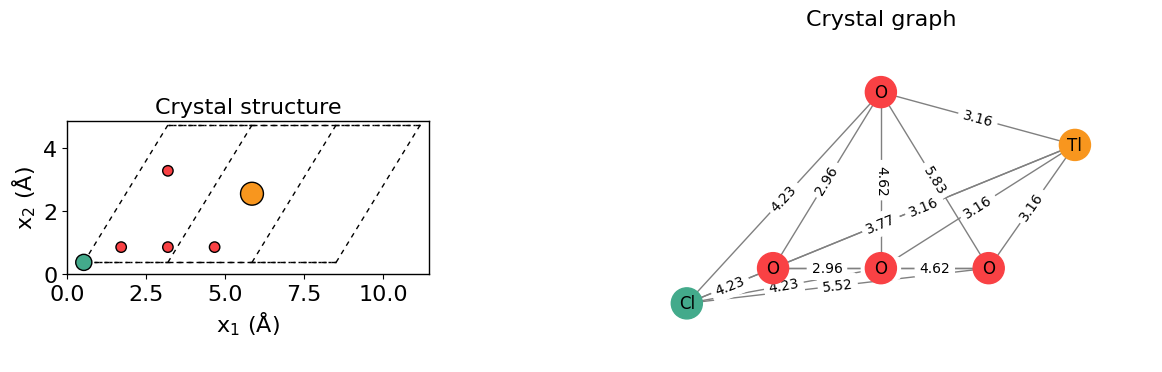

In [19]:
i = 16 # structure index in dataframe
plt.plot(df['data'][i].y.reshape(-1))
plot_example(df, i=i, label_edges=True)

## Train, Validation and Testing Datasets

In [12]:
#run_time = time.strftime('%y%m%d', time.localtime())
run_time = '250507'
# train/valid/test split
idx_train, idx_valid, idx_test = train_valid_test_split(df, species, valid_size=.1, test_size=.1, seed=12, plot=False)
#Save train loss values sets
np.savetxt(PurePath(main_dir, 'model', f'idx_train_{run_time}.txt'), idx_train, fmt='%i', delimiter='\t')
np.savetxt(PurePath(main_dir, 'model', f'idx_valid_{run_time}.txt'), idx_valid, fmt='%i', delimiter='\t')
np.savetxt(PurePath(main_dir, 'model', f'idx_test_{run_time}.txt'), idx_test, fmt='%i', delimiter='\t')

# plt.savefig('data-split.pdf')
print(f'Runtime index: {run_time}')

split train/dev ...


100%|██████████| 81/81 [00:00<00:00, 290.43it/s]                                                                                                                                             


split valid/test ...


100%|██████████| 79/79 [00:00<00:00, 345.37it/s]                                                                                                                                             

number of training examples: 733
number of validation examples: 96
number of testing examples: 111
total number of examples: 940
Runtime index: 250507


In [13]:
# load train/valid/test indices

with open(PurePath(main_dir, 'model', f'idx_train_{run_time}.txt'), 'r') as f: idx_train = [int(i.split('\n')[0]) for i in f.readlines()]
with open(PurePath(main_dir, 'model', f'idx_valid_{run_time}.txt'), 'r') as f: idx_valid = [int(i.split('\n')[0]) for i in f.readlines()]
with open(PurePath(main_dir, 'model', f'idx_test_{run_time}.txt'), 'r') as f: idx_test = [int(i.split('\n')[0]) for i in f.readlines()]

# format dataloaders
batch_size = 1
dataloader_train = tg.loader.DataLoader(df.iloc[idx_train]['data'].values, batch_size=batch_size, shuffle=True)
dataloader_valid = tg.loader.DataLoader(df.iloc[idx_valid]['data'].values, batch_size=batch_size)
dataloader_test = tg.loader.DataLoader(df.iloc[idx_test]['data'].values, batch_size=batch_size)

In [14]:
next(iter(dataloader_test))

DataBatch(edge_index=[2, 442], y=[1], pos=[6, 3], lattice=[1, 3, 3], symbol=[1], x_mass=[6, 118], x_dipole=[6, 118], x_radius=[6, 118], z=[6, 118], edge_shift=[442, 3], edge_vec=[442, 3], edge_len=[1], batch=[6], ptr=[2])

average number of neighbors (train/valid/test): 51.03625673689368 / 53.18532818532819 / 48.39646869983949


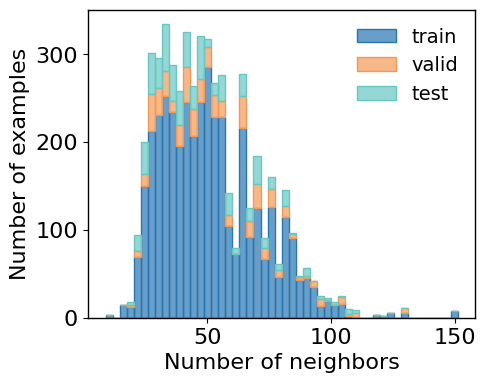

In [24]:
# calculate average number of neighbors
def get_neighbors(df, idx):
    n = []
    for entry in df.iloc[idx].itertuples():
        N = entry.data.pos.shape[0]
        for i in range(N):
            n.append(len((entry.data.edge_index[0] == i).nonzero()))
    return np.array(n)

n_train = get_neighbors(df, idx_train)
n_valid = get_neighbors(df, idx_valid)
n_test = get_neighbors(df, idx_test)

fig, ax = plt.subplots(1,1, figsize=(5,4))
b = 0.
bins = 50
for (d, c), n in zip(colors.items(), [n_train, n_valid, n_test]):
    color = [int(c.lstrip('#')[i:i+2], 16)/255. for i in (0,2,4)]
    y, bins, _, = ax.hist(n, bins=bins, fc=color+[0.7], ec=color, bottom=b, label=d)
    b += y
ax.set_xlabel('Number of neighbors')
ax.set_ylabel('Number of examples')
ax.legend(frameon=False)

print('average number of neighbors (train/valid/test):', n_train.mean(), '/', n_valid.mean(), '/', n_test.mean())

# Network Architecture

In [25]:
class MixingLinear(nn.Module):
    def __init__(self, in_feature, out_feature):
        super(MixingLinear, self).__init__()
        self.in_feature = in_feature
        self.out_feature = out_feature
        self.weight = nn.Parameter(torch.Tensor(self.out_feature, self.in_feature))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=5**0.5)

    def forward(self, x):
        weight = torch.abs(self.weight)/(torch.sum(torch.abs(self.weight), dim=1, keepdim=True)+1e-10)
        return F.linear(x, weight)


---

### 1 **Create Node Embeddings**

$$
h = Linear(x)
$$ <br>
где $h \in \R^{N \times em-dim}$

---

### 2 **Create edge attributes** <br>

##### 2.1 **Spherical Harmonics** <br>

$$
Y_{lm}(\theta, \phi) = \sqrt{\frac{(2l + 1)}{4\pi} \frac{(l - m)!}{(l + m)!}} P_{lm}(\cos \theta) e^{im\phi}
$$

где:
- $( l )$ — орбитальное квантовое число (степень),
- $( m )$ — магнитное квантовое число ($( -l \leq m \leq l )$),
- $( \theta )$ — азимутальный угол (в полярной системе координат),
- $( \phi )$ — полярный угол,
- $( P_{lm} )$ — присоединенные полиномы Лежандра.

Примеры:
- $( Y_{00}(\theta, \phi) = \frac{1}{\sqrt{4\pi}} )$.
- $( Y_{10}(\theta, \phi) = \sqrt{\frac{3}{4\pi}} \cos \theta )$.
- $( Y_{11}(\theta, \phi) = -\sqrt{\frac{3}{8\pi}} \sin \theta e^{i\phi} )$.

Spherical Harmonics are not learnable


##### 2.2 **Radial Harmonics with Gaussian basis**

$$
R_{n}(r) = \sum_{i=1}^{N} c_i \exp\left(-\alpha_i r^2\right)
$$

где:
- $( r )$ — расстояние между атомами,
- $( N )$ — число базисных функций (обычно $( N )$ фиксировано),
- $( c_i )$ — коэффициенты базисных функций (определяются во время обучения),
- $( \alpha_i )$ — параметры, контролирующие форму гауссовых функций.

Пример для $( N = 3 )$:

$$
R_{n}(r) = c_1 \exp(-\alpha_1 r^2) + c_2 \exp(-\alpha_2 r^2) + c_3 \exp(-\alpha_3 r^2)
$$


---

###  3 **Convolution Network**<br>

$
h^{'}_i = \frac{1}{\sqrt{z}} \sum_j{ W_l \dot [h_j \times F_{ij}]}
$

$
F_{ij} = R_n(r_{ij}) \times Y_{lm}(\theta_{ij}, \phi_{ij})
$

где:
- $( r_{ij} )$ — расстояние между атомами $( i )$ и $( j )$.
- $( \theta_{ij} )$ и $( \phi_{ij} )$ — углы в сферической системе координат, определяющие направление вектора $( \vec{r_{ij}} )$.
- $( R_n(r_{ij}) )$ — радиальная функция на основе гауссового базиса
- $( h_j )$ - эмбеддинг соседнего атома


Для фильтра с $( l = 1, m = 0 $) и $( N = 2 $), формула будет выглядеть так:

$
F_{ij} = \left[c_1 \exp(-\alpha_1 r_{ij}^2) + c_2 \exp(-\alpha_2 r_{ij}^2)\right] \times \sqrt{\frac{3}{4\pi}} \cos \theta_{ij}
$

где:
- $( c_1, c_2 )$ — обучаемые параметры сети.
- $( \alpha_1, \alpha_2 )$ — фиксированные параметры, задающие форму гауссовых функций.

---

- Радиальная функция $( R_n(r_{ij}) )$ отвечает за зависимость от расстояния $( r_{ij} )$ между атомами.
- Сферическая гармоника $( Y_{lm}(\theta_{ij}, \phi_{ij}) )$ отвечает за угловую зависимость направления между атомами.
- Применяя фильтр $( F_{ij} )$ к признакам узлов в графе, мы делаем их зависимыми как от расстояния, так и от углового расположения атомов.

---
### 4 **Gate Network**<br>

- $x_i$ - irreps scalars <br>
- $\phi_i$ - act scalars

$
\sum_i{\phi_i(x_i)}
$

- $g_j$ - irreps gates <br>
- $\phi_j$ - act gates <br>
- $y_j$ - irreps gated <br>

$
\sum_j{\phi_j(g_j)y_j}
$

Output: <br>
$
\sum_i{\phi_i(x_i)} + \sum_j{\phi_j(g_j)y_j}
$



Gate использует два основных типа данных:
- **Скаляры (независимые от ориентации)** — $( x_s )$.
- **Векторные или тензорные величины (зависят от ориентации)** — $( x_g )$.

$
x_s' = \sigma \left( W_s \cdot x_s \right)
$

$
x_g' = G \times x_g
$

где:
- $( x_s )$ — входные скалярные признаки (например, плотность, энергия).
- $( x_g )$ — входные признаки, зависящие от ориентации (например, силы, векторные компоненты).
- $( W_s )$ — обучаемая матрица весов для скаляров.
- $( \sigma )$ — нелинейная функция активации (например, $( \text{sigmoid} )$ или $( \text{tanh} )$).
- $( G )$ — весовые коэффициенты (гейты), определяемые через скаляры.

Гейты $( G )$ зависят от скалярных характеристик узлов и задаются в виде:

$
G = \sigma(W_g \cdot x_s)
$

где:
- $( W_g )$ — обучаемая матрица весов для гейтов.
- $( \sigma )$ — функция активации гейта (обычно $( \text{sigmoid} )$).

---

Пример для Gate с конкретной конфигурацией

Допустим:
- $( x_s )$ — плотность атома (скаляр).
- $( x_g )$ — сила на атоме (вектор $( \vec{F} )$).
- $( W_s = 0.5 )$, $( W_g = 1.2 )$.
- Используется $( \sigma = \text{sigmoid} )$.

- Для скалярного выхода:
$
x_s' = \sigma (0.5 \times x_s)
$

- Для выхода через гейт:
$
G = \sigma(1.2 \times x_s)
$

- Итоговый векторный выход:
$
x_g' = G \times x_g = \sigma(1.2 \times x_s) \times \vec{F}
$

---

Связь с фильтром на основе сферических и радиальных гармоник

Если $( x_g )$ — это функция от фильтра $( F_{ij} )$ (радиальной и угловой зависимостей):

$
x_g' = \sigma(1.2 \times x_s) \times \left[ R_n(r_{ij}) Y_{lm}(\theta_{ij}, \phi_{ij}) \right]
$

где:
- Радиальная функция $( R_n )$ задает зависимость от расстояния $( r_{ij} )$.
- Сферическая гармоника $( Y_{lm} )$ — от углов $( \theta_{ij}, \phi_{ij} )$.
- Гейт $( G )$ масштабирует эти признаки на основе скалярных свойств узлов.

---
### 5 **Multilayer Network** <br>

$$
x^{l+1} = Gate(Convolution(x^{l}))
$$
---
### 6 **Prediction** <br>
$$
E = \sum_{i=1}^{N} Linear(h_{i}')
$$

In [26]:
class Network(torch.nn.Module):
    r"""equivariant neural network
    Parameters
    ----------
    irreps_in : `e3nn.o3.Irreps` or None
        representation of the input features
        can be set to ``None`` if nodes don't have input features
    irreps_hidden : `e3nn.o3.Irreps`
        representation of the hidden features
    irreps_out : `e3nn.o3.Irreps`
        representation of the output features
    irreps_node_attr : `e3nn.o3.Irreps` or None
        representation of the nodes attributes
        can be set to ``None`` if nodes don't have attributes
    irreps_edge_attr : `e3nn.o3.Irreps`
        representation of the edge attributes
        the edge attributes are :math:`h(r) Y(\vec r / r)`
        where :math:`h` is a smooth function that goes to zero at ``max_radius``
        and :math:`Y` are the spherical harmonics polynomials
    layers : int
        number of gates (non linearities)
    max_radius : float
        maximum radius for the convolution
    number_of_basis : int
        number of basis on which the edge length are projected
    radial_layers : int
        number of hidden layers in the radial fully connected network
    radial_neurons : int
        number of neurons in the hidden layers of the radial fully connected network
    num_neighbors : float
        typical number of nodes at a distance ``max_radius``
    num_nodes : float
        typical number of nodes in a graph
    """
    def __init__(
        self,
        irreps_in,
        irreps_out,
        irreps_node_attr,
        layers,
        mul,
        lmax,
        max_radius,
        number_of_basis=10,
        radial_layers=1,
        radial_neurons=100,
        num_neighbors=1.,
        num_nodes=1.,
        reduce_output=True,
    ) -> None:
        super().__init__()
        self.mul = mul
        self.lmax = lmax
        self.max_radius = max_radius
        self.number_of_basis = number_of_basis
        self.num_neighbors = num_neighbors
        self.num_nodes = num_nodes
        self.reduce_output = reduce_output

        self.irreps_in = o3.Irreps(irreps_in) if irreps_in is not None else None
        self.irreps_hidden = o3.Irreps([(self.mul, (l, p)) for l in range(lmax + 1) for p in [-1, 1]])
        self.irreps_out = o3.Irreps(irreps_out)
        self.irreps_node_attr = o3.Irreps(irreps_node_attr) if irreps_node_attr is not None else o3.Irreps("0e")
        self.irreps_edge_attr = o3.Irreps.spherical_harmonics(lmax)

        self.input_has_node_in = (irreps_in is not None)
        self.input_has_node_attr = (irreps_node_attr is not None)

        irreps = self.irreps_in if self.irreps_in is not None else o3.Irreps("0e")

        act = {
            1: torch.nn.functional.silu,
            -1: torch.tanh,
        }
        act_gates = {
            1: torch.sigmoid,
            -1: torch.tanh,
        }

        self.layers = torch.nn.ModuleList()

        for _ in range(layers):
            irreps_scalars = o3.Irreps([(mul, ir) for mul, ir in self.irreps_hidden if ir.l == 0 and tp_path_exists(irreps, self.irreps_edge_attr, ir)])
            irreps_gated = o3.Irreps([(mul, ir) for mul, ir in self.irreps_hidden if ir.l > 0 and tp_path_exists(irreps, self.irreps_edge_attr, ir)])
            ir = "0e" if tp_path_exists(irreps, self.irreps_edge_attr, "0e") else "0o"
            irreps_gates = o3.Irreps([(mul, ir) for mul, _ in irreps_gated])

            gate = Gate(
                irreps_scalars, [act[ir.p] for _, ir in irreps_scalars],  # scalar
                irreps_gates, [act_gates[ir.p] for _, ir in irreps_gates],  # gates (scalars)
                irreps_gated  # gated tensors
            )
            # SUM[ f(x)(node_features)  X  f(r_ij)(edge_length_embedded) * Y(x_ij)(edge_attr) ]
            conv = Convolution(
                irreps,
                self.irreps_node_attr,
                self.irreps_edge_attr,
                gate.irreps_in,
                number_of_basis,
                radial_layers,
                radial_neurons,
                num_neighbors
            )
            irreps = gate.irreps_out
            self.layers.append(CustomCompose(conv, gate))

        self.layers.append(
            Convolution(
                irreps,
                self.irreps_node_attr,
                self.irreps_edge_attr,
                self.irreps_out,
                number_of_basis,
                radial_layers,
                radial_neurons,
                num_neighbors
            )
        )

    def preprocess(self, data: Union[Data, Dict[str, torch.Tensor]]) -> torch.Tensor:
        if 'batch' in data:
            batch = data['batch']
        else:
            batch = data['pos'].new_zeros(data['pos'].shape[0], dtype=torch.long)

        if 'edge_index' in data:
            edge_src = data['edge_index'][0]  # edge source
            edge_dst = data['edge_index'][1]  # edge destination
            edge_vec = data['edge_vec']
        
        else:
            edge_index = radius_graph(data['pos'], self.max_radius, batch)
            edge_src = edge_index[0]
            edge_dst = edge_index[1]
            edge_vec = data['pos'][edge_src] - data['pos'][edge_dst]

        return batch, edge_src, edge_dst, edge_vec

    def forward(self, data: Union[Data, Dict[str, torch.Tensor]]) -> torch.Tensor:
        """evaluate the network
        Parameters
        ----------
        data : `torch_geometric.data.Data` or dict
            data object containing
            - ``pos`` the position of the nodes (atoms)
            - ``x`` the input features of the nodes, optional
            - ``z`` the attributes of the nodes, for instance the atom type, optional
            - ``batch`` the graph to which the node belong, optional
        """
        batch, edge_src, edge_dst, edge_vec = self.preprocess(data)
        # Apply spherical harmonics to angles: Y(x_ij)
        edge_sh = o3.spherical_harmonics(self.irreps_edge_attr, edge_vec, True, normalization='component')
        # Calculate length between atoms r_ij
        edge_length = edge_vec.norm(dim=1)
        # Apply f(r_ij)-radial function(exponential) to r_ij
        edge_length_embedded = soft_one_hot_linspace(
            x=edge_length,
            start=0.0,
            end=self.max_radius,
            number=self.number_of_basis,
            basis='gaussian',
            cutoff=False
        ).mul(self.number_of_basis**0.5)
        # Y(x_ij) with cutoff radius
        edge_attr = smooth_cutoff(edge_length / self.max_radius)[:, None] * edge_sh

        if self.input_has_node_in and 'x' in data:
            assert self.irreps_in is not None
            x = data['x']
        else:
            assert self.irreps_in is None
            x = data['pos'].new_ones((data['pos'].shape[0], 1))

        if self.input_has_node_attr and 'z' in data:
            z = data['z']
        else:
            assert self.irreps_node_attr == o3.Irreps("0e")
            z = data['pos'].new_ones((data['pos'].shape[0], 1))

        for lay in self.layers:
            x = lay(x, z, edge_src, edge_dst, edge_attr, edge_length_embedded)

        if self.reduce_output:
            return scatter(x, batch, dim=0).div(self.num_nodes**0.5)
        else:
            return x

In [27]:
class PeriodicNetwork(Network):
    def __init__(self, in_dim, em_dim, **kwargs):            
        # override the `reduce_output` keyword to instead perform an averge over atom contributions    
        self.pool = False
        self.em_dim = em_dim
        if kwargs['reduce_output'] == True:
            kwargs['reduce_output'] = False
            self.pool = True
            
        super().__init__(**kwargs)

        # embed the one-hot encoding
        self.em_type = nn.Linear(in_dim, self.em_dim)    #Linear layer for atom type
        self.em_mass = nn.Linear(in_dim, self.em_dim)    #Linear layer for atom mass
        self.em_dipole = nn.Linear(in_dim, self.em_dim)  #Linear layer for atom dipole polarizability
        self.em_radius = nn.Linear(in_dim, self.em_dim)  #Linear layer for atom covalent radius
        self.em_mixing = MixingLinear(3, 1)         #Linear layer for mixing the atom features (mass, dipole, radius)

    def forward(self, data: Union[tg.data.Data, Dict[str, torch.Tensor]]) -> torch.Tensor:
        data.z = F.relu(self.em_type(data.z))
        data.x_mass = F.relu(self.em_mass(data.x_mass))
        data.x_dipole = F.relu(self.em_dipole(data.x_dipole))
        data.x_radius = F.relu(self.em_radius(data.x_radius))
        tmp = torch.stack([data.x_mass, data.x_dipole, data.x_radius], dim=0)      # stack the atom features in shape (3, N, em_dim) 
        tmp2 = torch.permute(tmp, (1, 2, 0))                                       # permute the tensor to (N, em_dim, 3)
        data.x = torch.permute(self.em_mixing(tmp2),(2, 0, 1)).reshape(-1, self.em_dim) # reshape the tensor to (N, em_dim)
        output = super().forward(data)
        #print(output.shape)
        # ReLu for last convolution will force output positive value, if output have negative value, it step should be neglected
        output = torch.relu(output)
        
        # if pool_nodes was set to True, use scatter_mean to aggregate
        if self.pool == True:
            output = torch_scatter.scatter_mean(output, data.batch, dim=0)  # take mean over atoms per example
        
        # normalization output from 0 to 1
        #maxima, _ = torch.max(output, dim=1)
        #output = output.div(maxima.unsqueeze(1))
        return output


In [28]:
out_dim = 1 # len(df.iloc[0]['energies_interp'])      # about 200 points
em_dim = 64

model = PeriodicNetwork(
    in_dim=118,                            # dimension of one-hot encoding of atom type
    em_dim=em_dim,                         # dimension of atom-type embedding
    irreps_in=str(em_dim)+"x0e",           # em_dim scalars (L=0 and even parity) on each atom to represent atom type
    irreps_out=str(out_dim)+"x0e",         # out_dim scalars (L=0 and even parity) to output
    irreps_node_attr=str(em_dim)+"x0e",    # em_dim scalars (L=0 and even parity) on each atom to represent atom type
    layers=2,                              # number of nonlinearities (number of convolutions = layers + 1)
    mul=32,                                # multiplicity of irreducible representations
    lmax=2,                                # maximum order of spherical harmonics
    max_radius=r_max,                      # cutoff radius for convolution
    num_neighbors=n_train.mean(),          # scaling factor based on the typical number of neighbors
    reduce_output=True                     # whether or not to aggregate features of all atoms at the end
)

print(model)

PeriodicNetwork(
  (layers): ModuleList(
    (0): CustomCompose(
      (first): Convolution(
        (sc): FullyConnectedTensorProduct(64x0e x 64x0e -> 96x0e+32x1o+32x2e | 393216 paths | 393216 weights)
        (lin1): FullyConnectedTensorProduct(64x0e x 64x0e -> 64x0e | 262144 paths | 262144 weights)
        (fc): FullyConnectedNet[10, 100, 192]
        (tp): TensorProduct(64x0e x 1x0e+1x1o+1x2e -> 64x0e+64x1o+64x2e | 192 paths | 192 weights)
        (lin2): FullyConnectedTensorProduct(64x0e+64x1o+64x2e x 64x0e -> 96x0e+32x1o+32x2e | 655360 paths | 655360 weights)
      )
      (second): Gate (96x0e+32x1o+32x2e -> 32x0e+32x1o+32x2e)
    )
    (1): CustomCompose(
      (first): Convolution(
        (sc): FullyConnectedTensorProduct(32x0e+32x1o+32x2e x 64x0e -> 160x0e+32x1o+32x1e+32x2o+32x2e | 458752 paths | 458752 weights)
        (lin1): FullyConnectedTensorProduct(32x0e+32x1o+32x2e x 64x0e -> 32x0e+32x1o+32x2e | 196608 paths | 196608 weights)
        (fc): FullyConnectedNet[10, 100, 

# Training

In [29]:
def visualize_layers(model):
    layer_dst = dict(zip(['sc', 'lin1', 'tp', 'lin2'], ['gate', 'tp', 'lin2', 'gate']))
    try: layers = model.mp.layers
    except: layers = model.layers

    num_layers = len(layers)
    num_ops = max([len([k for k in list(layers[i].first._modules.keys()) if k not in ['fc', 'alpha']])
                   for i in range(num_layers-1)])

    fig, ax = plt.subplots(num_layers, num_ops, figsize=(14,3.5*num_layers))
    for i in range(num_layers - 1):
        ops = layers[i].first._modules.copy()
        ops.pop('fc', None); ops.pop('alpha', None)
        for j, (k, v) in enumerate(ops.items()):
            ax[i,j].set_title(k, fontsize=textsize)
            v.cpu().visualize(ax=ax[i,j])
            ax[i,j].text(0.7,-0.15,'--> to ' + layer_dst[k], fontsize=textsize-2, transform=ax[i,j].transAxes)

    layer_dst = dict(zip(['sc', 'lin1', 'tp', 'lin2'], ['output', 'tp', 'lin2', 'output']))
    ops = layers[-1]._modules.copy()
    ops.pop('fc', None); ops.pop('alpha', None)
    for j, (k, v) in enumerate(ops.items()):
        ax[-1,j].set_title(k, fontsize=textsize)
        v.cpu().visualize(ax=ax[-1,j])
        ax[-1,j].text(0.7,-0.15,'--> to ' + layer_dst[k], fontsize=textsize-2, transform=ax[-1,j].transAxes)

    fig.subplots_adjust(wspace=0.3, hspace=0.5)

def loglinspace(rate, step, end=None):
    t = 0
    while end is None or t <= end:
        yield t
        t = int(t + 1 + step*(1 - math.exp(-t*rate/step)))

In [30]:
def evaluate(model, dataloader, loss_fn, loss_fn_mae, device):
    model.eval()
    loss_cumulative = 0.
    loss_cumulative_mae = 0.
    start_time = time.time()
    with torch.no_grad():
        for j, d in enumerate(dataloader):
            d.to(device)
            output = model(d)
            loss = loss_fn(output, d.y).cpu()
            loss_mae = loss_fn_mae(output, d.y).cpu()
            loss_cumulative = loss_cumulative + loss.detach().item()
            loss_cumulative_mae = loss_cumulative_mae + loss_mae.detach().item()
    return loss_cumulative/len(dataloader), loss_cumulative_mae/len(dataloader)


def train(model, optimizer, dataloader_train, dataloader_valid, loss_fn, loss_fn_mae, run_name,
          max_iter=101, scheduler=None, device="cpu"):
    model.to(device)

    checkpoint_generator = loglinspace(0.3, 5)
    checkpoint = next(checkpoint_generator)
    start_time = time.time()


    try: model.load_state_dict(torch.load(run_name + '.torch')['state'])
    except:
        results = {}
        history = []
        s0 = 0
    else:
        results = torch.load(run_name + '.torch')
        history = results['history']
        s0 = history[-1]['step'] + 1


    for step in range(max_iter):
        model.train()
        loss_cumulative = 0.
        loss_cumulative_mae = 0.
        
        for j, d in tqdm(enumerate(dataloader_train), total=len(dataloader_train), bar_format=bar_format):
            d.to(device)
            output = model(d)
            loss = loss_fn(output, d.y).cpu()
            loss_mae = loss_fn_mae(output, d.y).cpu()
            loss_cumulative = loss_cumulative + loss.detach().item()
            loss_cumulative_mae = loss_cumulative_mae + loss_mae.detach().item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        end_time = time.time()
        wall = end_time - start_time

        if step == checkpoint:
            checkpoint = next(checkpoint_generator)
            assert checkpoint > step

            valid_avg_loss = evaluate(model, dataloader_valid, loss_fn, loss_fn_mae, device)
            train_avg_loss = evaluate(model, dataloader_train, loss_fn, loss_fn_mae, device)

            history.append({
                'step': s0 + step,
                'wall': wall,
                'batch': {
                    'loss': loss.item(),
                    'mean_abs': loss_mae.item(),
                },
                'valid': {
                    'loss': valid_avg_loss[0],
                    'mean_abs': valid_avg_loss[1],
                },
                'train': {
                    'loss': train_avg_loss[0],
                    'mean_abs': train_avg_loss[1],
                },
            })

            results = {
                'history': history,
                'state': model.state_dict()
            }

            print(f"Iteration {step+1:4d}   " +
                  f"train loss = {train_avg_loss[0]:8.4f}   " +
                  f"valid loss = {valid_avg_loss[0]:8.4f}   " +
                  f"elapsed time = {time.strftime('%H:%M:%S', time.gmtime(wall))}")
            
            weight = torch.abs(model.em_mixing.weight)/(torch.sum(torch.abs(model.em_mixing.weight), dim=1, keepdim=True)+1e-10)
            print(weight)

            with open(PurePath(main_dir, 'model', f'{run_name}.torch'), 'wb') as f:
                torch.save(results, f)
            
        if scheduler is not None:
            scheduler.step()

In [31]:
opt = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.96)

#loss_fn = torch.nn.HuberLoss()
loss_fn = torch.nn.MSELoss()
loss_fn_mae = torch.nn.L1Loss()

run_name = 'model_alpha_' + run_time
model.pool = True

In [38]:
train(model, opt, dataloader_train, dataloader_valid, loss_fn, loss_fn_mae, run_name, 
       max_iter=30, scheduler=None, device=device)

  0%|          | 0/733 [00:00<?, ?it/s]                                                                                                                                                      

/beegfs/home/khasan.akhmadiev/3.12-env/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/beegfs/home/khasan.akhmadiev/3.12-env/lib/python3.12/site-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
100%|██████████| 733/733 [00:41<00:00, 17.61it/s]                                                                                                                                            


Iteration    1   train loss =   1.1358   valid loss =   1.0369   elapsed time = 00:00:41
tensor([[0.1397, 0.3670, 0.4932]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 733/733 [00:40<00:00, 18.31it/s]                                                                                                                                            


Iteration    2   train loss =   0.8773   valid loss =   0.9815   elapsed time = 00:01:35
tensor([[0.1431, 0.3501, 0.5068]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 733/733 [00:41<00:00, 17.80it/s]                                                                                                                                            


Iteration    3   train loss =   0.9257   valid loss =   1.0247   elapsed time = 00:02:28
tensor([[0.1720, 0.3493, 0.4787]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 733/733 [00:39<00:00, 18.43it/s]                                                                                                                                            


Iteration    4   train loss =   0.8996   valid loss =   0.8726   elapsed time = 00:03:21
tensor([[0.1931, 0.3410, 0.4658]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 733/733 [00:39<00:00, 18.57it/s]                                                                                                                                            


Iteration    5   train loss =   0.7751   valid loss =   0.8573   elapsed time = 00:04:13
tensor([[0.2310, 0.2972, 0.4717]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 733/733 [00:39<00:00, 18.58it/s]                                                                                                                                            


Iteration    7   train loss =   0.7916   valid loss =   0.9347   elapsed time = 00:05:47
tensor([[0.1188, 0.3266, 0.5546]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 733/733 [00:39<00:00, 18.39it/s]                                                                                                                                            


Iteration    9   train loss =   0.8265   valid loss =   0.9273   elapsed time = 00:07:20
tensor([[0.2230, 0.4966, 0.2804]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 733/733 [00:40<00:00, 18.20it/s]                                                                                                                                            


Iteration   11   train loss =   0.8524   valid loss =   0.8799   elapsed time = 00:08:52
tensor([[0.3958, 0.3499, 0.2542]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 733/733 [00:40<00:00, 18.12it/s]                                                                                                                                            


Iteration   14   train loss =   0.7265   valid loss =   0.8819   elapsed time = 00:11:06
tensor([[0.2481, 0.3736, 0.3783]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 733/733 [00:40<00:00, 18.19it/s]                                                                                                                                            


Iteration   17   train loss =   0.6554   valid loss =   0.7244   elapsed time = 00:13:18
tensor([[0.3213, 0.4399, 0.2388]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 733/733 [00:40<00:00, 18.26it/s]                                                                                                                                            


Iteration   21   train loss =   0.9668   valid loss =   1.0652   elapsed time = 00:16:11
tensor([[0.3248, 0.4475, 0.2277]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 733/733 [00:40<00:00, 18.25it/s]                                                                                                                                            


Iteration   25   train loss =   0.6723   valid loss =   0.7445   elapsed time = 00:19:03
tensor([[0.6052, 0.3116, 0.0832]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 733/733 [00:40<00:00, 18.05it/s]                                                                                                                                            


Iteration   29   train loss =   0.6397   valid loss =   0.7434   elapsed time = 00:21:57
tensor([[0.4799, 0.4080, 0.1121]], device='cuda:0', grad_fn=<DivBackward0>)


100%|██████████| 733/733 [00:40<00:00, 18.02it/s]                                                                                                                                            


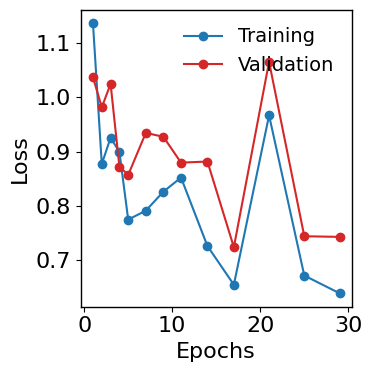

In [39]:
# load pre-trained model and plot its training history
#run_name = 'model_alpha_mass_' + run_time
history = torch.load(PurePath(main_dir, 'model', f'{run_name}.torch'), map_location=device)['history']
steps = [d['step'] + 1 for d in history]
loss_train = [d['train']['loss'] for d in history]
loss_valid = [d['valid']['loss'] for d in history]

np.savetxt(main_dir / f'{run_name}_MSE_loss.txt', np.column_stack((steps, loss_train, loss_valid)), fmt='%.8f', delimiter='\t')

fig, ax = plt.subplots(figsize=(4,4))
ax.plot(steps, loss_train, 'o-', label="Training", color='C0')
ax.plot(steps, loss_valid, 'o-', label="Validation", color='C3')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend(frameon=False)
plt.tight_layout()
fig.savefig(main_dir / f'{run_name}_loss.pdf')

# Results

In [32]:
# predict on all data
model.load_state_dict(torch.load(PurePath(main_dir, 'model', f'{run_name}.torch'), map_location=device)['state']) # run_name
model.pool = True

dataloader = tg.loader.DataLoader(df['data'].values, batch_size=64)
df['mse'] = 0.
df['y_pred'] = np.empty((len(df), 0)).tolist()

model.to(device)
model.eval()

# weight contribution of each feature
weight = torch.abs(model.em_mixing.weight)/(torch.sum(torch.abs(model.em_mixing.weight), dim=1, keepdim=True)+1e-10)
print(weight)

with torch.no_grad():
    i0 = 0
    for i, d in tqdm(enumerate(dataloader), total=len(dataloader), bar_format=bar_format):
        d.to(device)
        output = model(d)
        loss = F.mse_loss(output, d.y, reduction='none').mean(dim=-1).cpu().numpy()
        df.loc[i0:i0 + len(d.y) - 1, 'y_pred'] = [[k] for k in output.cpu().numpy()]
        df.loc[i0:i0 + len(d.y) - 1, 'mse'] = loss
        i0 += len(d.y)
        
df['y_pred'] = df['y_pred'].map(lambda x: x[0]) #*scale_data

tensor([[0.4799, 0.4080, 0.1121]], device='cuda:0', grad_fn=<DivBackward0>)


  0%|          | 0/15 [00:00<?, ?it/s]                                                                                                                                                       /tmp/ipykernel_659639/1146255489.py:21: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, d.y, reduction='none').mean(dim=-1).cpu().numpy()
  7%|▋         | 1/15 [00:02<00:28,  2.01s/it]                                                                                                                                               /tmp/ipykernel_659639/1146255489.py:21: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, d.y, red

ValueError: x and y must have same first dimension, but have shapes (251,) and (1,)

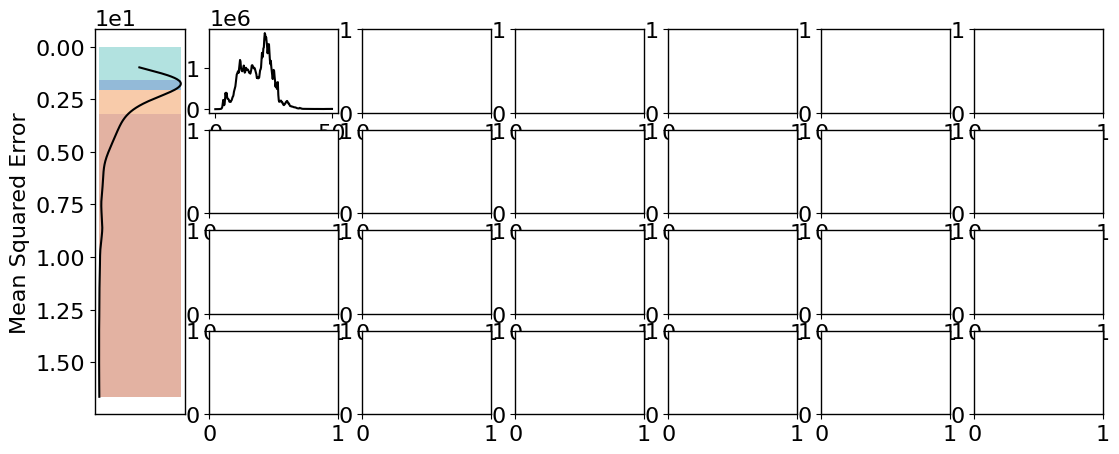

In [33]:
def plot_predictions(df, idx, column, header, title=None, plot_gt=True):    
    # get quartiles
    i_mse = np.argsort(df.iloc[idx]['mse'])
    ds = df.iloc[idx].iloc[i_mse][['formula','energies_interp', column, 'y_pred', 'mse']].reset_index(drop=True)
    quartiles = np.quantile(ds['mse'].values, (0.25, 0.5, 0.75, 1.))
    iq = [0] + [np.argmin(np.abs(ds['mse'].values - k)) for k in quartiles]
    
    n = 6
    s = np.concatenate([np.sort(np.random.choice(np.arange(iq[k-1], iq[k], 1), size=n, replace=False)) for k in range(1,5)])
    x = df.iloc[0]['energies_interp']

    fig, axs = plt.subplots(4,n+1, figsize=(13,5), gridspec_kw={'width_ratios': [0.7] + [1]*n})
    gs = axs[0,0].get_gridspec()
    
    # remove the underlying axes
    for ax in axs[:,0]:
        ax.remove()

    # add long axis
    axl = fig.add_subplot(gs[:,0])

    # plot quartile distribution
    y_min, y_max = ds['mse'].min(), ds['mse'].max()
    y = np.linspace(y_min, y_max, 500)
    kde = gaussian_kde(ds['mse'])
    p = kde.pdf(y)
    axl.plot(p, y, color='black')
    cols = [palette[k] for k in [2,0,1,3]][::-1]
    qs =  list(quartiles)[::-1] + [0]
    for i in range(len(qs)-1):
        axl.fill_between([p.min(), p.max()], y1=[qs[i], qs[i]], y2=[qs[i+1], qs[i+1]], color=cols[i], lw=0, alpha=0.5)
    axl.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    axl.invert_yaxis()
    axl.set_xticks([])
    axl.set_ylabel('Mean Squared Error')

    fontsize = 14
    cols = np.repeat(cols[::-1], n)
    axs = axs[:,1:].ravel()
    for k in range(4*n):
        ax = axs[k]
        i = s[k]
        if plot_gt:
            ax.plot(x, ds.iloc[i][column], color='black')
        ax.plot(x, ds.iloc[i]['y_pred'], color=cols[k])
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(ds.iloc[i]['formula'].translate(sub), fontname='DejaVu Sans', fontsize=fontsize, y=1.0)
        
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.5)
    if title: fig.suptitle(title, ha='center', y=1.05, fontsize=fontsize + 4)
    fig.savefig(f"{header}_{title}_spectra.pdf")
    
plot_predictions(df, idx_train, column='absorption_coefficient_interp', header=run_name, title='Training')

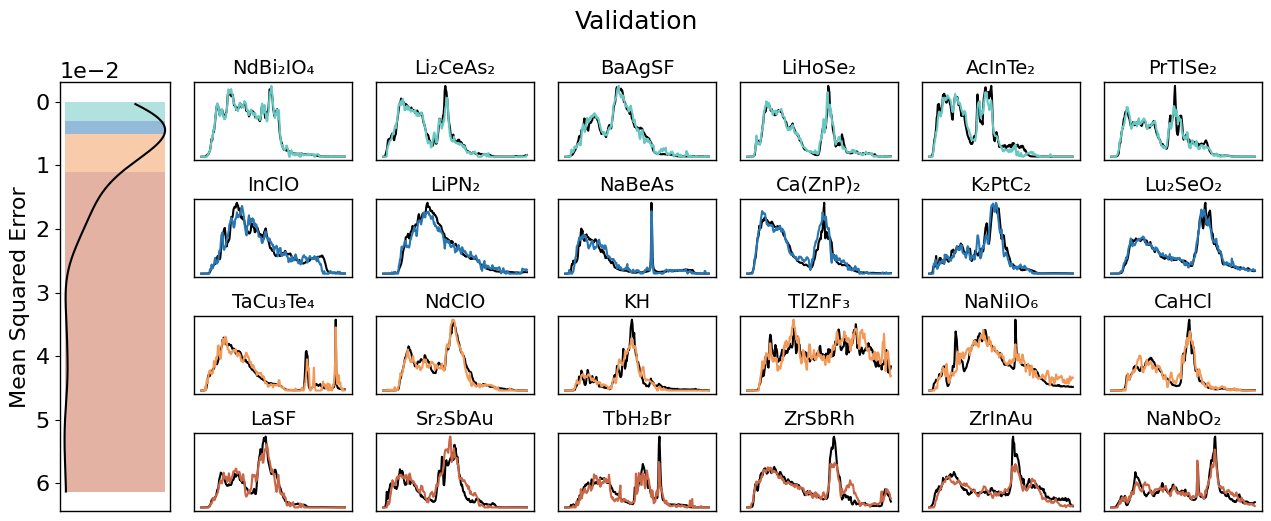

In [30]:
plot_predictions(df, idx_valid, column='absorption_coefficient_interp', header=run_name, title='Validation')

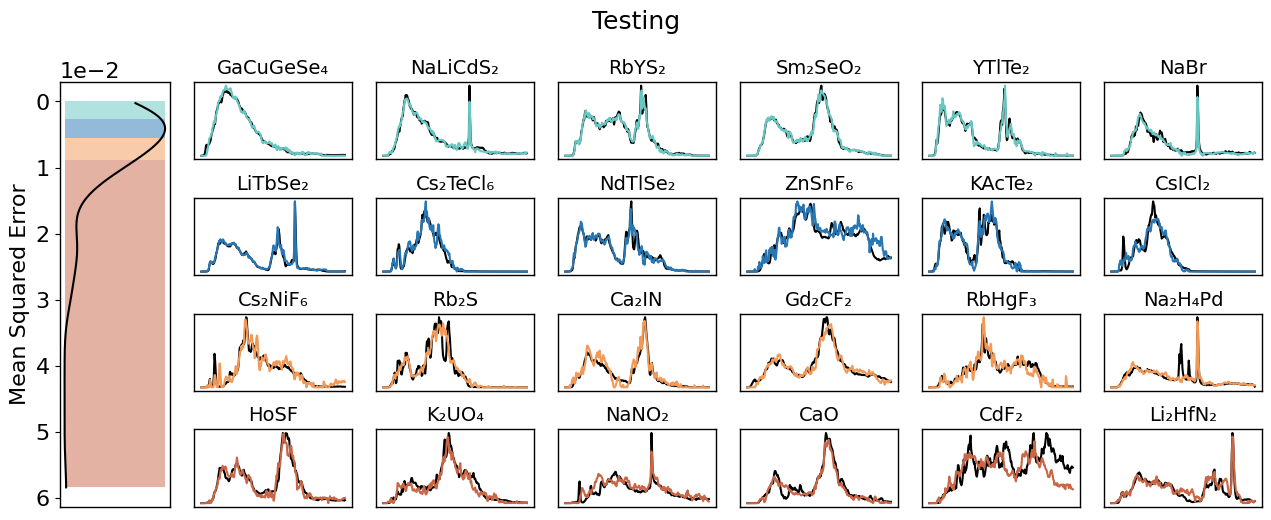

In [31]:
plot_predictions(df, idx_test, column='absorption_coefficient_interp', header=run_name, title='Testing')

In [34]:
def weighted_mean(x, y):
    """
    Calculate the weighted mean of Y with respect to X for each row.
    
    Parameters:
        x (array-like): Array of X values with shape (n_rows, n_columns).
        y (array-like): Array of Y values with shape (n_rows, n_columns).
        
    Returns:
        array-like: Weighted mean of Y with respect to X for each row.
    """
    weighted_sum = np.sum(x * y, axis=1)  # Sum along each row
    sum_of_weights = np.sum(x, axis=1)  # Sum along each row
    weighted_mean = weighted_sum / sum_of_weights
    return weighted_mean

def r2_score(y_true, y_pred):
    """
    Calculate the R^2 (coefficient of determination) value between true and predicted values.
    
    Parameters:
        y_true (array-like): Array of true Y values.
        y_pred (array-like): Array of predicted Y values.
        
    Returns:
        float: R^2 value.
    """
    # Calculate the mean of true values
    y_true_mean = np.mean(y_true)
    # Calculate the total sum of squares
    ss_total = np.sum((y_true - y_true_mean) ** 2)
    # Calculate the residual sum of squares
    ss_residual = np.sum((y_true - y_pred) ** 2)
    # Calculate R^2
    r_squared = 1 - (ss_residual / ss_total)
    return r_squared

R^2 (Train) = -1357.5702 R^2 (Valid) = -204.1592 R^2 (Test) = -251.4859


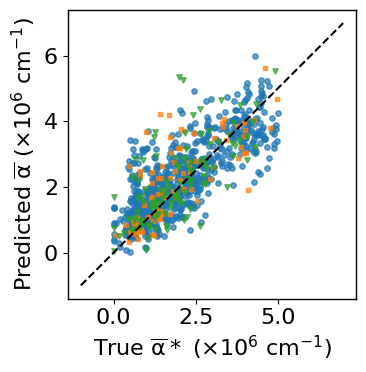

In [35]:
column = 'bandgap'

df_tr = df.iloc[idx_train][['formula','energies_interp', column, 'y_pred', 'mse']]
dx_tr = np.array([df_tr.iloc[i]['energies_interp'] for i in range(len(df_tr))])
gt_tr = np.array([df_tr.iloc[i][column] for i in range(len(df_tr))])
pr_tr = np.array([df_tr.iloc[i]['y_pred'] for i in range(len(df_tr))])
# Weighted mean of ground true and predicted values.
wgt_tr = gt_tr.copy() #weighted_mean(dx_tr, gt_tr)/1.0E6
wpr_tr = pr_tr.copy() #weighted_mean(dx_tr, pr_tr)/1.0E6
# Calculate R^2 value
r2_tr = r2_score(wgt_tr, wpr_tr)

df_va = df.iloc[idx_valid][['formula','energies_interp', column, 'y_pred', 'mse']]
dx_va = np.array([df_va.iloc[i]['energies_interp'] for i in range(len(df_va))])
gt_va = np.array([df_va.iloc[i][column] for i in range(len(df_va))])
pr_va = np.array([df_va.iloc[i]['y_pred'] for i in range(len(df_va))])
# Weighted mean of ground true and predicted values.
wgt_va = gt_va.copy() #weighted_mean(dx_va, gt_va)/1.0E6
wpr_va = pr_va.copy() #weighted_mean(dx_va, pr_va)/1.0E6
# Calculate R^2 value
r2_va = r2_score(wgt_va, wpr_va)

df_te = df.iloc[idx_test][['formula','energies_interp', column, 'y_pred', 'mse']]
dx_te = np.array([df_te.iloc[i]['energies_interp'] for i in range(len(df_te))])
gt_te = np.array([df_te.iloc[i][column] for i in range(len(df_te))])
pr_te = np.array([df_te.iloc[i]['y_pred'] for i in range(len(df_te))])
# Weighted mean of ground true and predicted values.
wgt_te = gt_te.copy() #weighted_mean(dx_te, gt_te)/1.0E6
wpr_te = pr_te.copy() #weighted_mean(dx_te, pr_te)/1.0E6
# Calculate R^2 value
r2_te = r2_score(wgt_te, wpr_te)

print('R^2 (Train) = {:.4f}'.format(r2_tr), 'R^2 (Valid) = {:.4f}'.format(r2_va), 'R^2 (Test) = {:.4f}'.format(r2_te))

# Plot the correction between ground true and predicted values.
fig, ax = plt.subplots(figsize=(4,4))
# print(len(wgt_tr[0]))
# print(len(wpr_tr[0]))
# Add a diagonal line for reference
min_val = min(np.min(wgt_tr), np.min(wpr_tr), np.min(wgt_va), np.min(wpr_va), np.min(wgt_te), np.min(wpr_te))
max_val = max(np.max(wgt_tr), np.max(wpr_tr), np.max(wgt_va), np.max(wpr_va), np.max(wgt_te), np.max(wpr_te))
width = max_val - min_val
ax.plot([min_val-1, max_val+1], [min_val-1, max_val+1], 'k--', label='Perfect Correlation')

ax.scatter(wgt_tr, wpr_tr, s=15, marker ="o", alpha=0.7, color='C0', label='Train')
ax.scatter(wgt_va, wpr_va, s=12, marker ="s", alpha=0.7, color='C1', label='Valid')
ax.scatter(wgt_te, wpr_te, s=15, marker ="v", alpha=0.7, color='C2', label='Test')

ax.set_xlabel(r'True $\overline{\alpha}*$ ($\times 10^6$ cm$^{-1}$)')
ax.set_ylabel(r'Predicted $\overline{\alpha}$ ($\times 10^6$ cm$^{-1}$)')

#ax.set_xlim(min_val-0.01*width, max_val+0.01*width)
#ax.set_ylim(min_val-0.01*width, max_val+0.01*width)
#ax.set_xlim(0.0, 1.3)
#ax.set_ylim(0.0, 1.3)
# Set the tick distance
# x_ticks = np.arange(0, 1.3, 0.3) 
# ax.set_xticks(x_ticks)
# y_ticks = np.arange(0, 1.3, 0.3) 
# ax.set_yticks(y_ticks)
ax.set_aspect('equal')
#plt.text(0.7, 0.36, r'$R^2$ (Train) = {:.4f}'.format(r2_tr), fontsize = 12, color = 'C0')
#plt.text(0.7, 0.24, r'$R^2$ (Valid) = {:.4f}'.format(r2_va), fontsize = 12, color = 'C1')
#plt.text(0.7, 0.12, r'$R^2$ (Test) = {:.4f}'.format(r2_te), fontsize = 12, color = 'C2')

plt.tight_layout()
fig.savefig(run_name + '_correlation.pdf')

plt.show()

# My Material

In [36]:
def build_data_for_predict(entry, type_encoding, type_onehot, r_max=5.):
    symbols = list(entry.structure.symbols).copy()
    positions = torch.from_numpy(entry.structure.positions.copy())
    lattice = torch.from_numpy(entry.structure.cell.array.copy()).unsqueeze(0)

    # edge_src and edge_dst are the indices of the central and neighboring atom, respectively
    # edge_shift indicates whether the neighbors are in different images or copies of the unit cell
    edge_src, edge_dst, edge_shift = neighbor_list("ijS", a=entry.structure, cutoff=r_max, self_interaction=True)
    
    # compute the relative distances and unit cell shifts from periodic boundaries
    edge_batch = positions.new_zeros(positions.shape[0], dtype=torch.long)[torch.from_numpy(edge_src)]
    edge_vec = (positions[torch.from_numpy(edge_dst)]
                - positions[torch.from_numpy(edge_src)]
                + torch.einsum('ni,nij->nj', torch.tensor(edge_shift, dtype=default_dtype), lattice[edge_batch]))

    # compute edge lengths (rounded only for plotting purposes)
    edge_len = np.around(edge_vec.norm(dim=1).numpy(), decimals=2)
    
    data = tg.data.Data(
        pos=positions, lattice=lattice, symbol=symbols,
        x_mass=mass_onehot[[type_encoding[specie] for specie in symbols]],       # atomic mass (node feature)
        x_dipole=dipole_onehot[[type_encoding[specie] for specie in symbols]],   # atomic dipole polarizability (node feature)
        x_radius=radius_onehot[[type_encoding[specie] for specie in symbols]],   # atomic covalent radius (node feature)
        z=type_onehot[[type_encoding[specie] for specie in symbols]],            # atom type (node attribute)
        edge_index=torch.stack([torch.LongTensor(edge_src), torch.LongTensor(edge_dst)], dim=0),
        edge_shift=torch.tensor(edge_shift, dtype=default_dtype),
        edge_vec=edge_vec, edge_len=edge_len,
        #y=torch.from_numpy(entry.absorption_coefficient_interp/scale_data).unsqueeze(0)
    )
    
    return data

In [37]:
from ase.io import read
from pymatgen.io.ase import AseAtomsAdaptor

ase_structures = read(main_dir / 'generated_crystals.extxyz', index=':')
print(ase_structures[0])
print("Атомы:", ase_structures[0].get_chemical_symbols())
print("Координаты:", ase_structures[0].get_positions())
print("Ячейка:", ase_structures[0].get_cell())
print("PBC:", ase_structures[0].get_pbc())

Atoms(symbols='NdGaOGeO4ZrO2', pbc=True, cell=[[4.9581990242004395, 0.0, -0.5512762069702148], [-0.8541764743259967, 5.509629688689856, -1.306960105895996], [0.0, 0.0, 5.718874931335449]])
Атомы: ['Nd', 'Ga', 'O', 'Ge', 'O', 'O', 'O', 'O', 'Zr', 'O', 'O']
Координаты: [[ 0.25790475  1.7778862  -0.26310193]
 [ 1.88448534  4.59805305  4.24290242]
 [ 4.25251816  1.00113891  2.93854554]
 [ 3.03780728  2.10892097  2.24538274]
 [ 0.88403774  3.96818835 -0.02943126]
 [ 0.72738159  5.40169823  3.05031977]
 [ 3.85159566  3.14819149  1.06526292]
 [ 2.54479621  2.91091332  3.75476597]
 [-0.29129735  5.07635217  1.25513971]
 [ 1.65255465  1.22705832  1.58335211]
 [ 4.19577539  0.06793693  0.38767353]]
Ячейка: Cell([[4.9581990242004395, 0.0, -0.5512762069702148], [-0.8541764743259967, 5.509629688689856, -1.306960105895996], [0.0, 0.0, 5.718874931335449]])
PBC: [ True  True  True]


In [38]:
from ase.io import read
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.analysis.structure_matcher import StructureMatcher
from mp_api.client import MPRester

api_key = 'wihuW5J4CTHX0JjEwxdyiP7XzPBi6sJh'
mpr = MPRester(api_key)


In [39]:
docs = []
max_num_atoms = 5
i = 0
for structure in ase_structures:
    # ASE → pymatgen
    structure = AseAtomsAdaptor.get_structure(structure)
    formula = structure.composition.reduced_formula

    # Получаем кандидатов с такой же формулой
    doc = mpr.materials.summary.search(formula=formula, fields=["material_id", "structure", "formula_pretty", "band_gap"])

    if doc and doc[0].band_gap > 2 and doc[0].band_gap < 4:
        docs.append(doc[0])
        i += 1
        if i > max_num_atoms:
            break

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/43 [00:00<?, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/3 [00:00<?, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/2 [00:00<?, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents: 0it [00:00, ?it/s]

Retrieving SummaryDoc documents:   0%|          | 0/7 [00:00<?, ?it/s]

In [40]:
my_struc_df = pd.DataFrame()
formula = []
structure = []
species = []
dft_bandgap = []

for doc in docs:
    dft_bandgap.append(doc.band_gap)
    atoms = AseAtomsAdaptor.get_atoms(doc.structure)
    formula.append(atoms.get_chemical_formula())
    structure.append(atoms)
    species.append(np.unique(atoms.get_chemical_symbols()))

In [41]:
dft_bandgap = np.array(dft_bandgap)
my_struc_df['formula'] = formula
my_struc_df['structure'] = structure
my_struc_df['species'] = species
my_struc_df

,formula,structure,species
0,O10Si4,"(Atom('Si', [np.float64(2.2759189331103524), n...","[O, Si]"
1,I2Mg,"(Atom('Mg', [np.float64(0.0), np.float64(0.0),...","[I, Mg]"
2,B8Cs24O24,"(Atom('Cs', [np.float64(2.6111820732498634), n...","[B, Cs, O]"
3,CsI2Rb,"(Atom('Cs', [np.float64(0.0), np.float64(7.001...","[Cs, I, Rb]"
4,Nd4O16Sb4,"(Atom('Nd', [np.float64(1.5118462066012504), n...","[Nd, O, Sb]"
5,Ba2O8W2,"(Atom('Ba', [np.float64(1.4757085), np.float64...","[Ba, O, W]"


In [42]:
my_struc_df['data'] = my_struc_df.apply(lambda x: build_data_for_predict(x, type_encoding, type_onehot, r_max), axis=1)
my_struc_df['data'][0]

Data(edge_index=[2, 914], pos=[14, 3], lattice=[1, 3, 3], symbol=[14], x_mass=[14, 118], x_dipole=[14, 118], x_radius=[14, 118], z=[14, 118], edge_shift=[914, 3], edge_vec=[914, 3], edge_len=[914])

In [43]:
dataloader_for_predict = tg.loader.DataLoader(my_struc_df['data'].values, batch_size=len(my_struc_df['data'].values), shuffle=False)
next(iter(dataloader_for_predict))

DataBatch(edge_index=[2, 5597], pos=[113, 3], lattice=[6, 3, 3], symbol=[6], x_mass=[113, 118], x_dipole=[113, 118], x_radius=[113, 118], z=[113, 118], edge_shift=[5597, 3], edge_vec=[5597, 3], edge_len=[6], batch=[113], ptr=[7])

In [44]:
model.load_state_dict(torch.load(PurePath(main_dir, 'model', f'{run_name}.torch'), map_location=device)['state']) # run_name
model.pool = True

d = next(iter(dataloader_for_predict)).to(device)
model.to(device)
model.eval()

# weight contribution of each feature
# weight = torch.abs(model.em_mixing.weight)/(torch.sum(torch.abs(model.em_mixing.weight), dim=1, keepdim=True)+1e-10)
# print(weight)


output = model(d).detach().cpu().numpy().squeeze(-1)
output

array([1.76331328, 4.05803406, 2.0417969 , 2.15475249, 2.6339359 ,
       2.05034591])

In [50]:
my_struc_df.formula

0       O10Si4
1         I2Mg
2    B8Cs24O24
3       CsI2Rb
4    Nd4O16Sb4
5      Ba2O8W2
Name: formula, dtype: object

In [ ]:
def pretty_formula(formula: str) -> str:
    """Преобразует химическую формулу, заменяя цифры на нижние индексы Unicode."""
    subscript_map = str.maketrans('0123456789', '₀₁₂₃₄₅₆₇₈₉')
    result = ''
    i = 0
    while i < len(formula):
        if formula[i].isalpha():
            # Начало нового элемента
            result += formula[i]
            i += 1
            # Проверим, есть ли вторая буква (например, 'r' в 'Sr')
            if i < len(formula) and formula[i].islower():
                result += formula[i]
                i += 1
        elif formula[i].isdigit():
            # Считаем всю цифру подряд (на случай >9)
            num = ''
            while i < len(formula) and formula[i].isdigit():
                num += formula[i]
                i += 1
            result += num.translate(subscript_map)
        else:
            # Просто добавить символ (на случай скобок и т.д.)
            result += formula[i]
            i += 1
    return result

pretty = [pretty_formula(f) for f in list(my_struc_df.formula)]
pretty

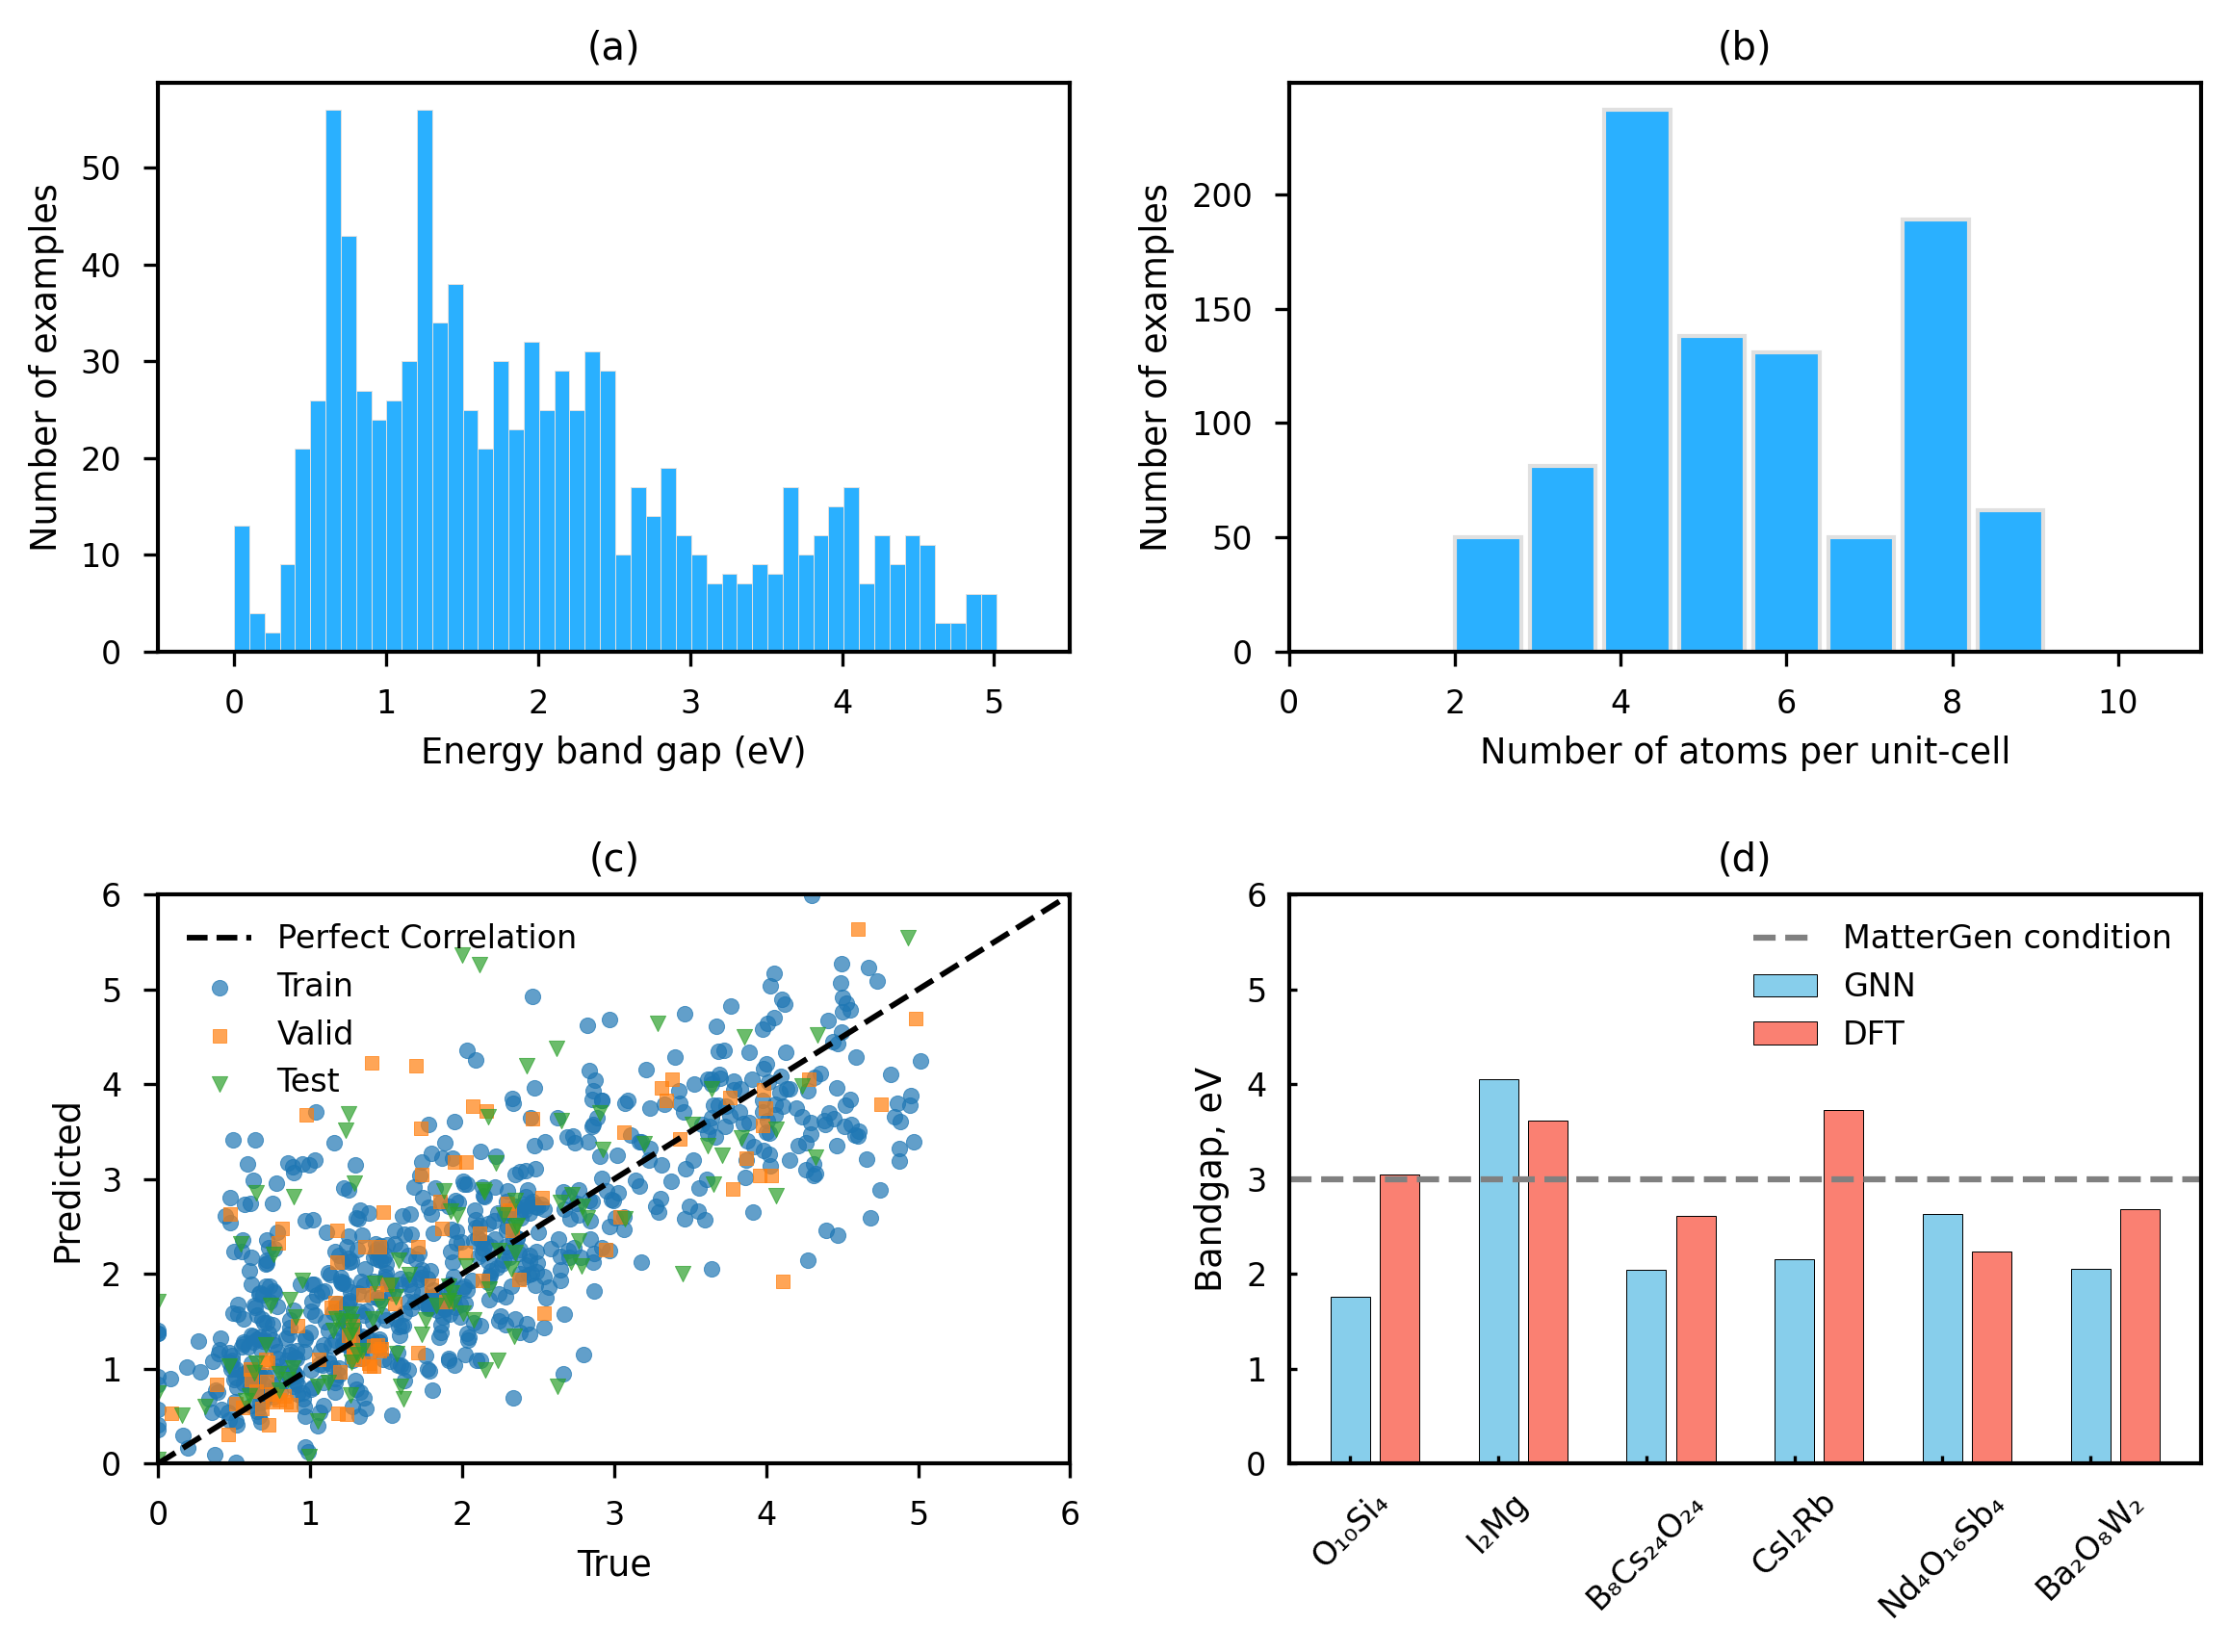

In [49]:
plt.style.use('seaborn-v0_8-paper')

fig, ax = plt.subplots(2, 2, figsize=(8, 6), dpi=300)


ax_ij = [0, 0]
bandgap = np.array(df['bandgap'])
ax[ax_ij[0], ax_ij[1]].hist(bandgap, bins=50, fc='#2ab0ff', ec='#e0e0e0')
ax[ax_ij[0], ax_ij[1]].set_xlim([-0.5, 5.5])
ax[ax_ij[0], ax_ij[1]].set_xticks(np.arange(0, 6, 1))
# ax[ax_ij[0], ax_ij[1]].set_ylim([0, 4000])
# ax[ax_ij[0], ax_ij[1]].set_yticks(range(0,4001,1000))
ax[ax_ij[0], ax_ij[1]].set_xlabel('Energy band gap (eV)')
ax[ax_ij[0], ax_ij[1]].set_ylabel('Number of examples')
ax[ax_ij[0], ax_ij[1]].set_title('(a)')

ax_ij = [0, 1]
# data statistics (#Atoms/cell)
sites = [len(s.get_positions()) for s in list(df['structure'])]
ax[ax_ij[0], ax_ij[1]].hist(sites, bins=max(sites), fc='#2ab0ff', ec='#e0e0e0', lw=1, width=0.8)
ax[ax_ij[0], ax_ij[1]].set_xlim(0.0, 11)
ax[ax_ij[0], ax_ij[1]].set_xticks(np.arange(0, 12, 2))
ax[ax_ij[0], ax_ij[1]].set_ylabel('Number of examples')
ax[ax_ij[0], ax_ij[1]].set_xlabel('Number of atoms per unit-cell')
# # ax[ax_ij[0], ax_ij[1]].set_ylim([0, 4000])
# # ax[ax_ij[0], ax_ij[1]].set_yticks(range(0,4001,1000))
# ax[ax_ij[0], ax_ij[1]].legend(['in', 'out', 'total'])
ax[ax_ij[0], ax_ij[1]].set_title('(b)')

ax_ij = [1, 0]
# Add a diagonal line for reference
min_val = min(np.min(wgt_tr), np.min(wpr_tr), np.min(wgt_va), np.min(wpr_va), np.min(wgt_te), np.min(wpr_te))
max_val = max(np.max(wgt_tr), np.max(wpr_tr), np.max(wgt_va), np.max(wpr_va), np.max(wgt_te), np.max(wpr_te))
width = max_val - min_val
ax[ax_ij[0], ax_ij[1]].plot([min_val-1, max_val+1], [min_val-1, max_val+1], 'k--', label='Perfect Correlation')

ax[ax_ij[0], ax_ij[1]].scatter(wgt_tr, wpr_tr, s=15, marker ="o", alpha=0.7, color='C0', label='Train')
ax[ax_ij[0], ax_ij[1]].scatter(wgt_va, wpr_va, s=12, marker ="s", alpha=0.7, color='C1', label='Valid')
ax[ax_ij[0], ax_ij[1]].scatter(wgt_te, wpr_te, s=15, marker ="v", alpha=0.7, color='C2', label='Test')
ax[ax_ij[0], ax_ij[1]].set_xlabel(r'True')
ax[ax_ij[0], ax_ij[1]].set_ylabel(r'Predicted')
ax[ax_ij[0], ax_ij[1]].set_ylim([0, 6])
ax[ax_ij[0], ax_ij[1]].set_xlim([0, 6])
ax[ax_ij[0], ax_ij[1]].legend(loc="upper left", fontsize=8, frameon=False)
ax[ax_ij[0], ax_ij[1]].set_title('(c)')

ax_ij = [1, 1]
ax[ax_ij[0], ax_ij[1]].bar(np.arange(0, len(output)*3, 3), output, color='skyblue', edgecolor='black', label='GNN')
ax[ax_ij[0], ax_ij[1]].bar(np.arange(1, len(output)*3, 3), dft_bandgap, color='salmon', edgecolor='black', label='DFT')

ax[ax_ij[0], ax_ij[1]].axhline(y=3, color='gray', linestyle='--', linewidth=1.5, label=f'MatterGen condition')

#ax[ax_ij[0], ax_ij[1]].set_xlim([0, 10])
ax[ax_ij[0], ax_ij[1]].set_xticks(ticks=np.arange(0, len(output)*3, 3), labels=pretty, rotation=45)
ax[ax_ij[0], ax_ij[1]].set_ylim([0, 6])
#ax[ax_ij[0], ax_ij[1]].set_yticks(range(-2000,4001,1000))
ax[ax_ij[0], ax_ij[1]].xaxis.set_ticks_position('bottom')
ax[ax_ij[0], ax_ij[1]].yaxis.set_ticks_position('left')
ax[ax_ij[0], ax_ij[1]].tick_params(axis='both', which='major', labelsize=8, direction='in', length=2)
ax[ax_ij[0], ax_ij[1]].legend(loc="upper right", fontsize=8, frameon=False)
ax[ax_ij[0], ax_ij[1]].set_xlabel('')
ax[ax_ij[0], ax_ij[1]].set_ylabel('Bandgap, eV')
ax[ax_ij[0], ax_ij[1]].set_title('(d)')

plt.tight_layout()
plt.show()


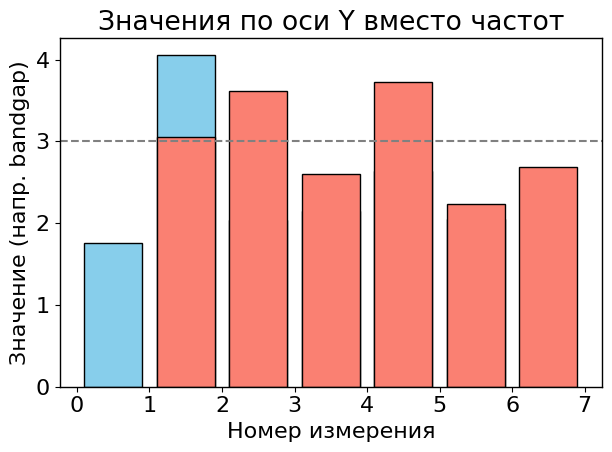

In [ ]:


# LOSS
plt.
plt

yline = 3
plt.axhline(y=yline, color='gray', linestyle='--', linewidth=1.5, label=f'MatterGen condition {yline:.1f}')

ax_ij = [0, 0]
ax[0, 0].loglog(loss[:, 4], label='Energy-train', color='blue', linewidth=1.5)
ax[0, 0].loglog(loss[:, 5], label='Force-train', color='red', linewidth=1.5)
ax[0, 0].set_xlabel('Generation/100', fontsize=8, fontweight='bold', labelpad=5)
ax[0, 0].set_ylabel('Bandgap, eV', fontsize=8, fontweight='bold', labelpad=5)

ax[0, 0].xaxis.set_ticks_position('bottom')
ax[0, 0].yaxis.set_ticks_position('left')
ax[0, 0].tick_params(axis='both', which='major', labelsize=8, direction='in', length=2)
ax[0, 0].legend(loc="upper right", fontsize=8, frameon=False)

# # ENERGY
# rmse_energy = RMSELoss(yhat=energy_test[:, 0], y=energy_test[:, 1])*1000
# ax[0, 1].scatter(energy_train[:, 1], energy_train[:, 0], marker='o', label='Energy-train', color='black', linewidth=1.5)
# ax[0, 1].scatter(energy_test[:, 1], energy_test[:, 0], marker='^', alpha=0.7, label='Energy-test', color='blue', linewidth=1.5)
# ax[0, 1].plot(linspace(-6.8, -6.45), linspace(-6.8, -6.45), ls='-', label='', color='red', linewidth=1.5)
# ax[0, 1].text(0.4, 0.2, f'RMSE = {rmse_energy:.2f} meV/atom', transform=ax[0, 1].transAxes, fontsize=8)
# ax[0, 1].set_xlabel('DFT energy (eV/atom)', fontsize=8, fontweight='bold', labelpad=5)
# ax[0, 1].set_ylabel('NEP energy (eV/atom)', fontsize=8, fontweight='bold', labelpad=5)
# ax[0, 1].xaxis.set_ticks_position('bottom')
# ax[0, 1].yaxis.set_ticks_position('left')
# ax[0, 1].tick_params(axis='both', which='major', labelsize=8, direction='in', length=2)
# ax[0, 1].legend(loc="upper left", fontsize=8, frameon=False)

# # FORCES
# step = 100
# dft_force_train = np.sqrt(force_train[::step, 3:4]**2 + force_train[::step, 4:5]**2 + force_train[::step, 5:6]**2)
# nep_force_train = np.sqrt(force_train[::step, 0:1]**2 + force_train[::step, 1:2]**2 + force_train[::step, 2:3]**2)

# dft_force_test = np.sqrt(force_test[::step, 3:4]**2 + force_test[::step, 4:5]**2 + force_test[::step, 5:6]**2)
# nep_force_test = np.sqrt(force_test[::step, 0:1]**2 + force_test[::step, 1:2]**2 + force_test[::step, 2:3]**2)

# rmse_forces = RMSELoss(yhat=nep_force_test, y=dft_force_test)*1000

# ax[1, 0].scatter(dft_force_train, nep_force_train, marker='o', label='Force-train', color='black', linewidth=1.5)
# ax[1, 0].scatter(dft_force_test, nep_force_test, marker='^', alpha=0.5, label='Force-test', color='blue', linewidth=1.5)

# ax[1, 0].plot(np.linspace(-0.5, 6), np.linspace(-0.5, 6), ls='-', label='', color='red', linewidth=1.5)
# ax[1, 0].text(0.4, 0.2, f'RMSE = {rmse_forces:.2f} meV/A', transform=ax[1, 0].transAxes, fontsize=8)
# ax[1, 0].set_xlabel('DFT force (eV/A)', fontsize=8, fontweight='bold', labelpad=5)
# ax[1, 0].set_ylabel('NEP force (eV/A)', fontsize=8, fontweight='bold', labelpad=5)
# ax[1, 0].xaxis.set_ticks_position('bottom')
# ax[1, 0].yaxis.set_ticks_position('left')
# ax[1, 0].tick_params(axis='both', which='major', labelsize=8, direction='in', length=2)
# ax[1, 0].legend(loc="upper left", fontsize=8, frameon=False)

# # PHONON STRUCTURE
# y_nep = (pts_phonon_nep.y*33.35641)
# y_dft = (pts_phonon_dft.y*33.35641)
# rmse_phonon_struc = RMSELoss(yhat=pts_phonon_nep.y.reshape(-1)*33.35641, y=pts_phonon_dft.y.reshape(-1)*33.35641)
# wmape_phonon_struc = WMAPELoss(yhat=pts_phonon_nep.y.reshape(-1)*33.35641, y=pts_phonon_dft.y.reshape(-1)*33.35641)
# ax[1, 1].plot(pts_phonon_nep.x.T[:, 0], y_nep.T[:, 0], ls='-', label='NEP', color='blue', linewidth=1)
# ax[1, 1].plot(pts_phonon_dft.x.T[:, 0], y_dft.T[:, 0], ls='dashed', label='DFT', color='red', linewidth=1)
# ax[1, 1].plot(pts_phonon_nep.x.T[:, 1:], y_nep.T[:, 1:], ls='-', label='', color='blue', linewidth=1)
# ax[1, 1].plot(pts_phonon_dft.x.T[:, 1:], y_dft.T[:, 1:], ls='dashed', label='', color='red', linewidth=1)
# ax[1, 1].text(0.4, 0.1, f'RMSE = {rmse_phonon_struc:.2f} cm\u207B\N{SUPERSCRIPT ONE}', transform=ax[1, 1].transAxes, fontsize=8)
# ax[1, 1].text(0.4, 0.05, f'WMAPE = {wmape_phonon_struc:.2f}%', transform=ax[1, 1].transAxes, fontsize=8)

# ax[1, 1].set_xlabel('', fontsize=8, fontweight='bold', labelpad=5)
# ax[1, 1].set_ylabel(f"Frequency (cm\u207B\N{SUPERSCRIPT ONE})", fontsize=8, fontweight='bold', labelpad=5)
# ax[1, 1].set_xlim([pts_phonon_dft.x.min(), pts_phonon_dft.x.max()])
# ax[1, 1].set_ylim([min(y_nep.min(), y_dft.min()), max(y_nep.max(), y_dft.max())])
# ax[1, 1].xaxis.set_ticks_position('bottom')
# ax[1, 1].yaxis.set_ticks_position('left')
# ax[1, 1].tick_params(axis='both', which='major', labelsize=8, direction='in', length=2)
# ax[1, 1].legend(loc="center left", bbox_to_anchor=(0.3, 1.03), ncol=2, fontsize=8, frameon=False) 

plt.tight_layout()
plt.show()



# # Подписи
# plt.xticks()
# plt.xlabel('')
# plt.ylabel('Bandgap, eV')
# plt.title('Значения по оси Y вместо частот')

# plt.tight_layout()
# plt.show()

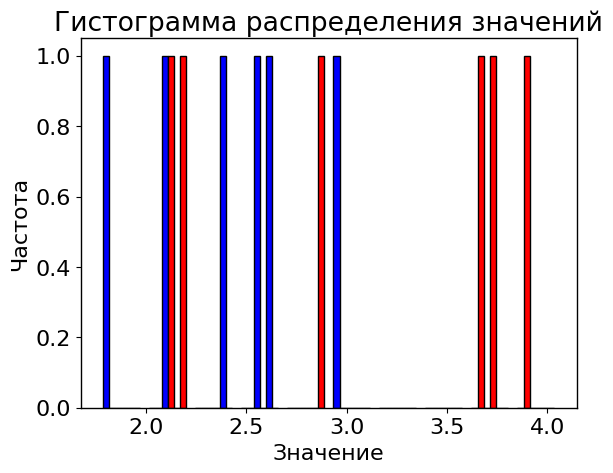

In [ ]:
plt.hist(list(zip(output, dft_bandgap)), bins=10, color=['blue', 'red']*3, edgecolor='black')

# Подписи и заголовок
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.title('Гистограмма распределения значений')

# Показать график
plt.show()

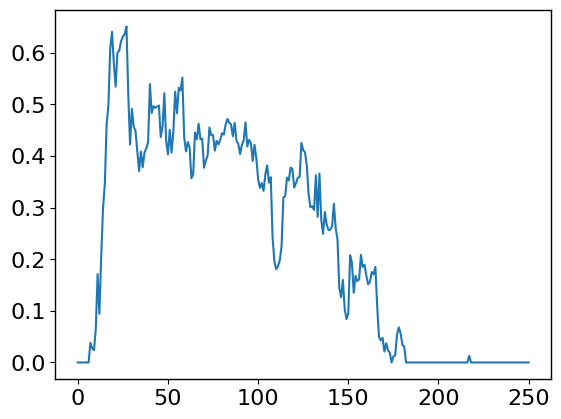

In [101]:
#fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plt.plot(output[0].detach().cpu())
plt.show()